First, we download the data from wandb:

In [1]:
import wandb
import pandas as pd
from collections.abc import MutableMapping

# Configuration
ENTITY = "loss-of-plasticity"
PROJECT = "continual-learning-experiments"

# Initialize API
api = wandb.Api()

# Fetch runs
runs = api.runs(f"{ENTITY}/{PROJECT}", per_page=1000, filters={"tags": "main"})

# Helper: Flatten nested configs
def flatten_dict(d, parent_key='', sep='.'):
    items = []
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, MutableMapping):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

# Collect all historical data
all_histories = []

for run in runs:
    if run.state != "finished":
        print(f"Skipping run {run.name} ({run.id}) — state: {run.state}")
        continue
    
    print(f"Downloading history for run: {run.name} ({run.id})")
    try:
        # Fetch full history (pagination is handled automatically here)
        history = run.history(samples=100000)  # Optional: increase samples if needed
        history["run_id"] = run.id
        history["run_name"] = run.name

        config = flatten_dict({k: v for k, v in run.config.items() if not k.startswith('_')})
        for key, value in config.items():
            if isinstance(value, (int, float, str, bool)) or value is None:
                history[key] = value
            else:
                # Skip non-scalar config values (e.g., lists, dicts)
                print(f"Skipping non-scalar config key: {key}")


        all_histories.append(history)

    except Exception as e:
        print(f"Failed to download history for run {run.id}: {e}")

# Concatenate all histories into a single DataFrame
df_all = pd.concat(all_histories, ignore_index=True)

# Optional: Save to CSV
# df_all.to_csv("wandb_all_history.csv", index=False)

# Preview
df_all.head()


Skipping non-scalar config key: model.hidden_sizes
Skipping non-scalar config key: metrics.monitor_filters
Skipping non-scalar config key: optimizer.betas
Skipping non-scalar config key: model.hidden_sizes
Skipping non-scalar config key: metrics.monitor_filters
Skipping non-scalar config key: optimizer.betas
Skipping non-scalar config key: model.hidden_sizes
Skipping non-scalar config key: metrics.monitor_filters
Skipping non-scalar config key: optimizer.betas
Skipping non-scalar config key: model.hidden_sizes
Skipping non-scalar config key: metrics.monitor_filters
Skipping non-scalar config key: optimizer.betas
Skipping non-scalar config key: metrics.monitor_filters
Skipping non-scalar config key: optimizer.betas
Skipping non-scalar config key: model.hidden_sizes
Skipping non-scalar config key: metrics.monitor_filters
Skipping non-scalar config key: optimizer.betas
Skipping non-scalar config key: model.hidden_sizes
Skipping non-scalar config key: metrics.monitor_filters
Skipping non-s

val/layers.norm_2/mean_of_means  \
0                    -2.014531e-09   
1                              NaN   
2                              NaN   
3                              NaN   
4                              NaN   

                      val/layers.act_2/act_stds_hist  \
0  {'bins': [0.603365957736969, 0.604451715946197...   
1                                               None   
2                                               None   
3                                               None   
4                                               None   

                    val/layers.norm_1/act_means_hist  \
0  {'_type': 'histogram', 'values': [1, 0, 0, 0, ...   
1                                               None   
2                                               None   
3                                               None   
4                                               None   

   train/layers.act_3/dead_fraction  train/layers.act_3/eff_rank  \
0                               0.0                    76.677673   
1                               NaN                          NaN   
2                               NaN                          NaN   
3                               NaN                          NaN   
4                               NaN                          NaN   

   val/layers.norm_4/stable_rank  \
0                      19.659659   
1                            NaN   
2                            NaN   
3                            NaN   
4                            NaN   

                      val/layers.act_0/act_stds_hist  \
0  {'values': [1, 0, 0, 0, 0, 0, 0, 1, 1, 2, 0, 0...   
1                                               None   
2                                               None   
3                                               None   
4                                               None   

                  train/layers.norm_4/act_means_hist   _runtime  \
0  {'_type': 'histogram', 'values': [1, 0, 0, 0, ...   2.186531   
1                                               None   6.302971   
2                                               None   8.391909   
3                                               None  10.432089   
4                                               None  12.542970   

                   train/layers.norm_2/act_stds_hist  ...  \
0  {'bins': [1.0038504600524902, 1.00385141372680...  ...   
1                                               None  ...   
2                                               None  ...   
3                                               None  ...   
4                                               None  ...   

   train/layers.flatten/non_gaussianity val/layers.conv_2/mean_of_stds  \
0                                   NaN                            NaN   
1                                   NaN                            NaN   
2                                   NaN                            NaN   
3                                   NaN                            NaN   
4                                   NaN                            NaN   

   train/layers.pool_1/mean_of_stds  train/layers.pool_2/mean_of_means  \
0                               NaN                                NaN   
1                               NaN                                NaN   
2                               NaN                                NaN   
3                               NaN                                NaN   
4                               NaN                                NaN   

   val/layers.flatten/saturated_frac  train/layers.conv_2/mean_of_stds  \
0                                NaN                               NaN   
1                                NaN                               NaN   
2                                NaN                               NaN   
3                                NaN                               NaN   
4                                NaN                               NaN   

   val/layers.conv_0/act_stds_hi

In [2]:
len(df_all)

588980

In [3]:
columns = list(df_all.columns)
# print all the columns in a structured way: for example, say we have columns a.b.c., a.b.d, and a.e , a.c.b: 
# a.
#   a.b. 
#     a.b.c
#     a.b.d
#   a.e
#   a.c
#   a.c.b
# same goes for the separator / for example a.b/c 

from collections import defaultdict
from pprint import pprint

columns_dict = {}
for col in columns:
    parts = col.split('.')
    current_dict = columns_dict
    for part in parts:
        if part not in current_dict:
            current_dict[part] = {}
        current_dict = current_dict[part]
    current_dict['__value__'] = col

def print_nested_dict(d, parent_key='', sep='.'):
    """Prints a nested dictionary in a structured way."""
    items = defaultdict(list)
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, MutableMapping):
            items[parent_key].append(new_key)
            items.update(print_nested_dict(v, new_key, sep=sep))
        else:
            items[parent_key].append(new_key)
    return items

pprint(print_nested_dict(columns_dict))

defaultdict(<class 'list'>,
            {'': ['val/layers',
                  'train/layers',
                  '_runtime',
                  'task_id',
                  'global_epoch',
                  'val_loss',
                  'local_epoch',
                  'local_step',
                  'train_loss',
                  '_step',
                  'val_acc',
                  '_timestamp',
                  'global_step',
                  'train_acc',
                  'run_id',
                  'run_name',
                  'model',
                  'dryrun',
                  'dataset',
                  'logging',
                  'metrics',
                  'training',
                  'optimizer',
                  'use_wandb',
                  'wandb_project'],
             '_runtime': ['_runtime.__value__'],
             '_step': ['_step.__value__'],
             '_timestamp': ['_timestamp.__value__'],
             'dataset': ['dataset.name',
                    

Filtering the dataframe for the "main" runs. Keeping only the finished ones.

In [4]:
main_df = df_all
main_df.head()

val/layers.norm_2/mean_of_means  \
0                    -2.014531e-09   
1                              NaN   
2                              NaN   
3                              NaN   
4                              NaN   

                      val/layers.act_2/act_stds_hist  \
0  {'bins': [0.603365957736969, 0.604451715946197...   
1                                               None   
2                                               None   
3                                               None   
4                                               None   

                    val/layers.norm_1/act_means_hist  \
0  {'_type': 'histogram', 'values': [1, 0, 0, 0, ...   
1                                               None   
2                                               None   
3                                               None   
4                                               None   

   train/layers.act_3/dead_fraction  train/layers.act_3/eff_rank  \
0                               0.0                    76.677673   
1                               NaN                          NaN   
2                               NaN                          NaN   
3                               NaN                          NaN   
4                               NaN                          NaN   

   val/layers.norm_4/stable_rank  \
0                      19.659659   
1                            NaN   
2                            NaN   
3                            NaN   
4                            NaN   

                      val/layers.act_0/act_stds_hist  \
0  {'values': [1, 0, 0, 0, 0, 0, 0, 1, 1, 2, 0, 0...   
1                                               None   
2                                               None   
3                                               None   
4                                               None   

                  train/layers.norm_4/act_means_hist   _runtime  \
0  {'_type': 'histogram', 'values': [1, 0, 0, 0, ...   2.186531   
1                                               None   6.302971   
2                                               None   8.391909   
3                                               None  10.432089   
4                                               None  12.542970   

                   train/layers.norm_2/act_stds_hist  ...  \
0  {'bins': [1.0038504600524902, 1.00385141372680...  ...   
1                                               None  ...   
2                                               None  ...   
3                                               None  ...   
4                                               None  ...   

   train/layers.flatten/non_gaussianity val/layers.conv_2/mean_of_stds  \
0                                   NaN                            NaN   
1                                   NaN                            NaN   
2                                   NaN                            NaN   
3                                   NaN                            NaN   
4                                   NaN                            NaN   

   train/layers.pool_1/mean_of_stds  train/layers.pool_2/mean_of_means  \
0                               NaN                                NaN   
1                               NaN                                NaN   
2                               NaN                                NaN   
3                               NaN                                NaN   
4                               NaN                                NaN   

   val/layers.flatten/saturated_frac  train/layers.conv_2/mean_of_stds  \
0                                NaN                               NaN   
1                                NaN                               NaN   
2                                NaN                               NaN   
3                                NaN                               NaN   
4                                NaN                               NaN   

   val/layers.conv_0/act_stds_hi

In [5]:
len(main_df)

588980

In [30]:
# Display the columns which contain 'saturated' in their name
saturated_columns = [col for col in list(main_df.columns) if 'saturated' in col]
print("Columns containing 'saturated':")    
for col in saturated_columns:
    print(col)

Columns containing 'saturated':
val/layers.act_2/saturated_frac
train/layers.act_4/saturated_frac
val/layers.norm_3/saturated_frac
train/layers.out/saturated_frac
train/layers.norm_2/saturated_frac
train/layers.linear_0/saturated_frac
val/layers.act_1/saturated_frac
val/layers.out/saturated_frac
val/layers.linear_0/saturated_frac
train/layers.linear_4/saturated_frac
train/layers.act_3/saturated_frac
train/layers.norm_3/saturated_frac
val/layers.act_3/saturated_frac
train/layers.norm_1/saturated_frac
val/layers.linear_2/saturated_frac
val/layers.norm_2/saturated_frac
val/layers.norm_0/saturated_frac
val/layers.act_0/saturated_frac
train/layers.act_2/saturated_frac
train/layers.act_1/saturated_frac
train/layers.norm_4/saturated_frac
val/layers.act_4/saturated_frac
train/layers.norm_0/saturated_frac
train/layers.linear_3/saturated_frac
val/layers.linear_1/saturated_frac
train/layers.linear_1/saturated_frac
val/layers.linear_3/saturated_frac
val/layers.linear_4/saturated_frac
train/layers.

In [6]:
# calculate how many nan rows there are for each column
nan_counts = main_df.isna().sum()
# Display the columns with more than 0 NaN values
nan_columns = nan_counts[nan_counts > 0].index.tolist()
print("Columns with NaN values:")
for col in nan_columns:
    print(f"{col}: {nan_counts[col]} NaN values")

Columns with NaN values:
val/layers.norm_2/mean_of_means: 570800 NaN values
val/layers.act_2/act_stds_hist: 570800 NaN values
val/layers.norm_1/act_means_hist: 570800 NaN values
train/layers.act_3/dead_fraction: 574840 NaN values
train/layers.act_3/eff_rank: 574840 NaN values
val/layers.norm_4/stable_rank: 574840 NaN values
val/layers.act_0/act_stds_hist: 570800 NaN values
train/layers.norm_4/act_means_hist: 574840 NaN values
train/layers.norm_2/act_stds_hist: 570800 NaN values
val/layers.act_0/std_of_stds: 570800 NaN values
val/layers.linear_3/act_means_hist: 574840 NaN values
train/layers.act_0/mean_of_means: 570800 NaN values
val/layers.linear_0/mean_of_means: 574840 NaN values
train/layers.linear_4/std_of_stds: 574840 NaN values
val/layers.linear_0/std_of_means: 574840 NaN values
train/layers.norm_4/std_of_means: 574840 NaN values
val/layers.out/dup_fraction: 570800 NaN values
val/layers.act_2/saturated_frac: 570800 NaN values
val/layers.norm_2/non_gaussianity: 570800 NaN values
tr

In [ ]:
# # drop the columns with more than 90% nan values
# nan_threshold = 0.9
# nan_counts = main_df.isna().sum()
# nan_columns = nan_counts[nan_counts > len(main_df) * nan_threshold].index.tolist()
# print("Dropping columns with more than 90% NaN values:")
# for col in nan_columns:
#     print(f"{col}: {nan_counts[col]} NaN values")
# main_df = main_df.drop(columns=nan_columns)

Dropping columns with more than 90% NaN values:
val/layers.norm_2/mean_of_means: 570941 NaN values
val/layers.act_2/act_stds_hist: 570941 NaN values
val/layers.norm_1/act_means_hist: 570941 NaN values
train/layers.act_3/dead_fraction: 574995 NaN values
train/layers.act_3/eff_rank: 574995 NaN values
val/layers.norm_4/stable_rank: 574995 NaN values
val/layers.act_0/act_stds_hist: 570941 NaN values
train/layers.norm_4/act_means_hist: 574995 NaN values
train/layers.norm_2/act_stds_hist: 570941 NaN values
val/layers.act_0/std_of_stds: 570941 NaN values
val/layers.linear_3/act_means_hist: 574995 NaN values
train/layers.act_0/mean_of_means: 570941 NaN values
val/layers.linear_0/mean_of_means: 574995 NaN values
train/layers.linear_4/std_of_stds: 574995 NaN values
val/layers.linear_0/std_of_means: 574995 NaN values
train/layers.norm_4/std_of_means: 574995 NaN values
val/layers.out/dup_fraction: 570941 NaN values
val/layers.act_2/saturated_frac: 570941 NaN values
val/layers.norm_2/non_gaussianit

In [ ]:
# # print all the columns with their nan values (0 if no nan values)
# nan_counts = main_df.isna().sum()
# print("Columns with NaN values:")
# for col in main_df.columns:
#     print(f"{col}: {nan_counts[col]} NaN values")

Columns with NaN values:
_runtime: 0 NaN values
task_id: 0 NaN values
global_epoch: 0 NaN values
val_loss: 99007 NaN values
local_epoch: 0 NaN values
local_step: 0 NaN values
train_loss: 99007 NaN values
_step: 0 NaN values
val_acc: 99007 NaN values
_timestamp: 0 NaN values
global_step: 0 NaN values
train_acc: 99007 NaN values
run_id: 0 NaN values
run_name: 0 NaN values
model.bias: 504995 NaN values
model.name: 0 NaN values
model._target_: 0 NaN values
model.dropout_p: 0 NaN values
model.activation: 0 NaN values
model.normalization: 0 NaN values
model.normalization_affine: 0 NaN values
model.norm_after_activation: 480800 NaN values
dryrun: 0 NaN values
dataset.name: 0 NaN values
dataset.img_size: 0 NaN values
dataset.input_size: 0 NaN values
dataset.in_channels: 0 NaN values
dataset.num_classes: 0 NaN values
logging.summary: 0 NaN values
logging.use_wandb: 456915 NaN values
logging.wandb_project: 456915 NaN values
metrics.corr_threshold: 0 NaN values
metrics.dead_threshold: 0 NaN value

In [44]:
quantity_cols = {}
for col in main_df.columns:
    parts = col.split('/')
    if len(parts) == 3:
        type = parts[0]
        layer = parts[1]
        quantity = parts[2]
        if 'act' in layer or 'block' in layer:
            if (type, quantity) not in quantity_cols:
                quantity_cols[(type, quantity)] = []
            quantity_cols[(type, quantity)].append(col)
    
quantity_cols

{('val', 'act_stds_hist'): ['val/layers.act_2/act_stds_hist',
  'val/layers.act_0/act_stds_hist',
  'val/layers.act_1/act_stds_hist',
  'val/layers.act_3/act_stds_hist',
  'val/layers.act_4/act_stds_hist',
  'val/layers.block_4/act_stds_hist',
  'val/layers.block_0/act_stds_hist',
  'val/layers.block_5/act_stds_hist',
  'val/layers.block_3/act_stds_hist',
  'val/layers.block_2/act_stds_hist',
  'val/layers.block_1/act_stds_hist',
  'val/layers.fc_act_0/act_stds_hist'],
 ('train', 'dead_fraction'): ['train/layers.act_3/dead_fraction',
  'train/layers.act_1/dead_fraction',
  'train/layers.act_4/dead_fraction',
  'train/layers.act_2/dead_fraction',
  'train/layers.act_0/dead_fraction',
  'train/layers.block_1/dead_fraction',
  'train/layers.block_0/dead_fraction',
  'train/layers.block_5/dead_fraction',
  'train/layers.block_2/dead_fraction',
  'train/layers.block_3/dead_fraction',
  'train/layers.block_4/dead_fraction',
  'train/layers.fc_act_0/dead_fraction'],
 ('train', 'eff_rank'): ['

In [45]:
# Calculate the mean of the columns for each quantity
df_avg = main_df.copy()

for (type, quantity), cols in quantity_cols.items():
    numerical_cols = [col for col in cols if df_avg[col].dtype.kind in 'bifc']
    if numerical_cols:
        df_avg[f"{type}_{quantity}"] = df_avg[numerical_cols].mean(axis=1)
    else:
        print(f"No numerical columns found for {type}_{quantity}")

No numerical columns found for val_act_stds_hist
No numerical columns found for val_act_means_hist
No numerical columns found for train_act_stds_hist
No numerical columns found for train_act_means_hist


In [46]:
list(df_avg.columns)

['val/layers.norm_2/mean_of_means',
 'val/layers.act_2/act_stds_hist',
 'val/layers.norm_1/act_means_hist',
 'train/layers.act_3/dead_fraction',
 'train/layers.act_3/eff_rank',
 'val/layers.norm_4/stable_rank',
 'val/layers.act_0/act_stds_hist',
 'train/layers.norm_4/act_means_hist',
 '_runtime',
 'train/layers.norm_2/act_stds_hist',
 'val/layers.act_0/std_of_stds',
 'val/layers.linear_3/act_means_hist',
 'train/layers.act_0/mean_of_means',
 'val/layers.linear_0/mean_of_means',
 'task_id',
 'train/layers.linear_4/std_of_stds',
 'val/layers.linear_0/std_of_means',
 'train/layers.norm_4/std_of_means',
 'val/layers.out/dup_fraction',
 'val/layers.act_2/saturated_frac',
 'val/layers.norm_2/non_gaussianity',
 'train/layers.norm_1/non_gaussianity',
 'val/layers.norm_2/act_stds_hist',
 'val/layers.act_2/eff_rank',
 'train/layers.norm_3/dup_fraction',
 'val/layers.norm_1/act_stds_hist',
 'train/layers.norm_4/mean_of_stds',
 'val/layers.act_2/mean_of_means',
 'train/layers.norm_0/act_means_hist

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set plotting style for publication-quality figures
sns.set_style("white", {"font.family": "serif", "font.weight": "normal", "font.serif": ["Times", "Palatino", "serif"]})
plt.rcParams.update({
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "font.family": "serif",
    "axes.titlesize": 18,
    "axes.labelsize": 16,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "axes.edgecolor": "black",
    "axes.linewidth": 1,
})

In [67]:
df_avg['global_epoch'].unique()

array([    0,     1,     2, ..., 19998, 19999, 20000], shape=(20001,))

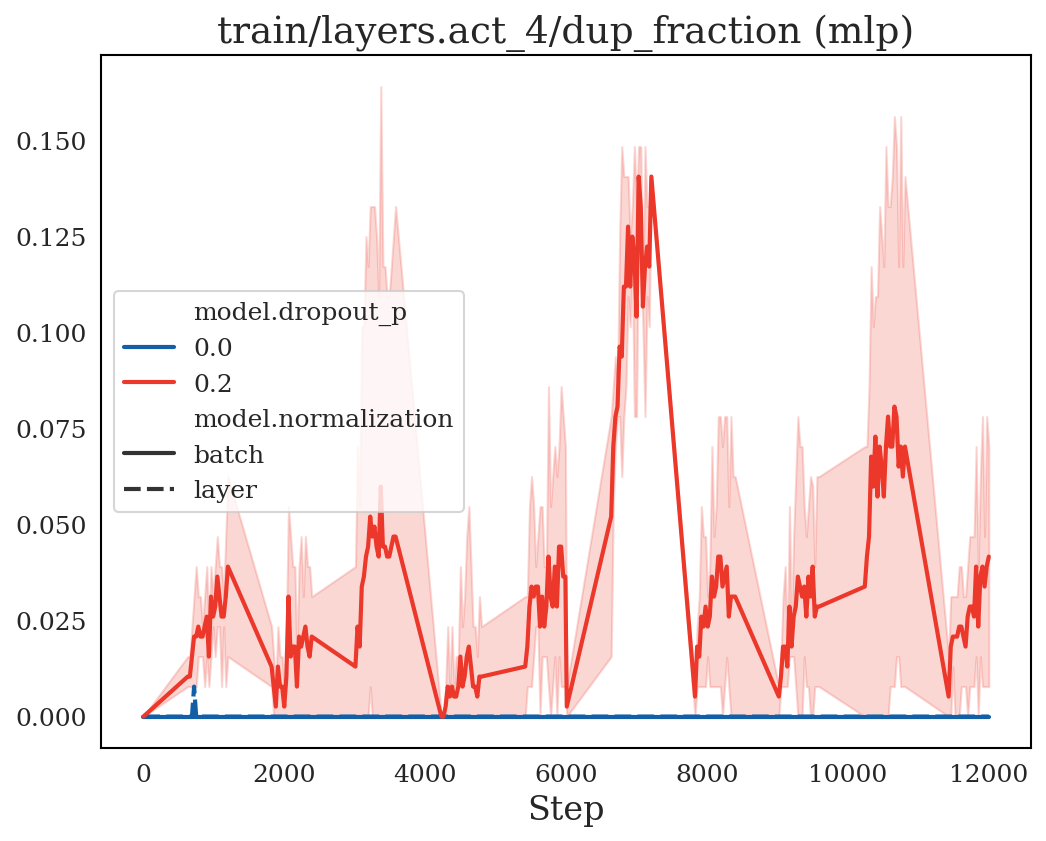

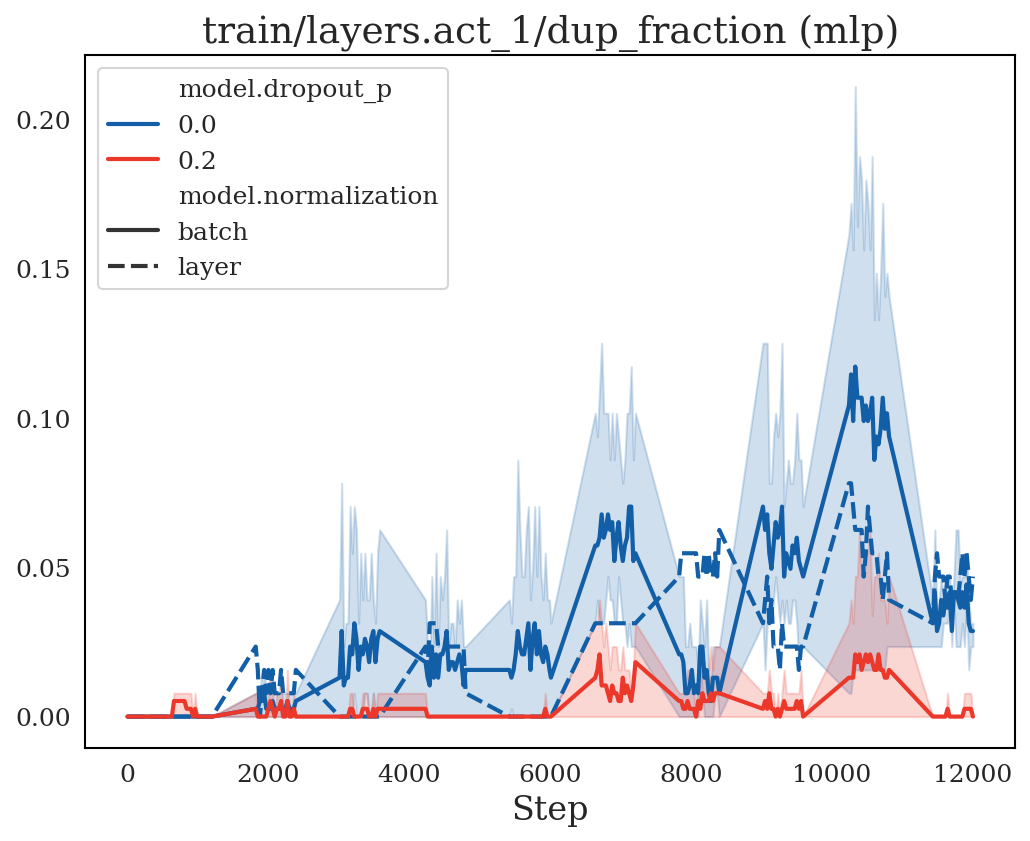

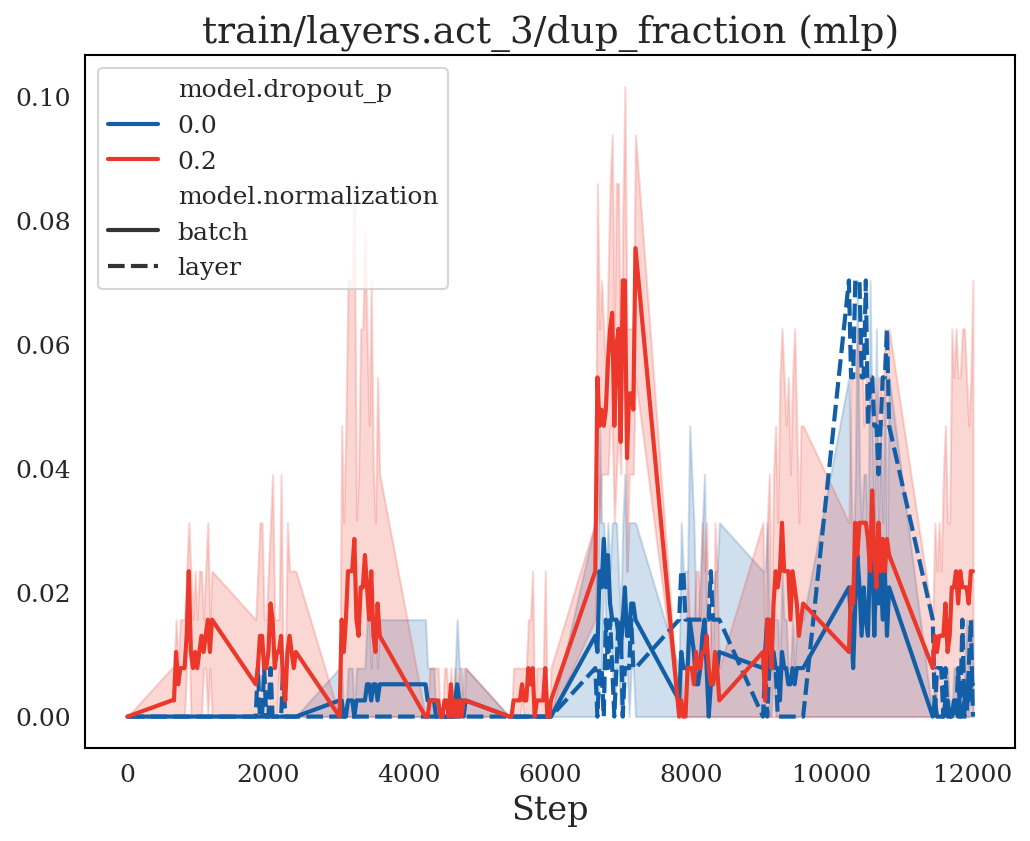

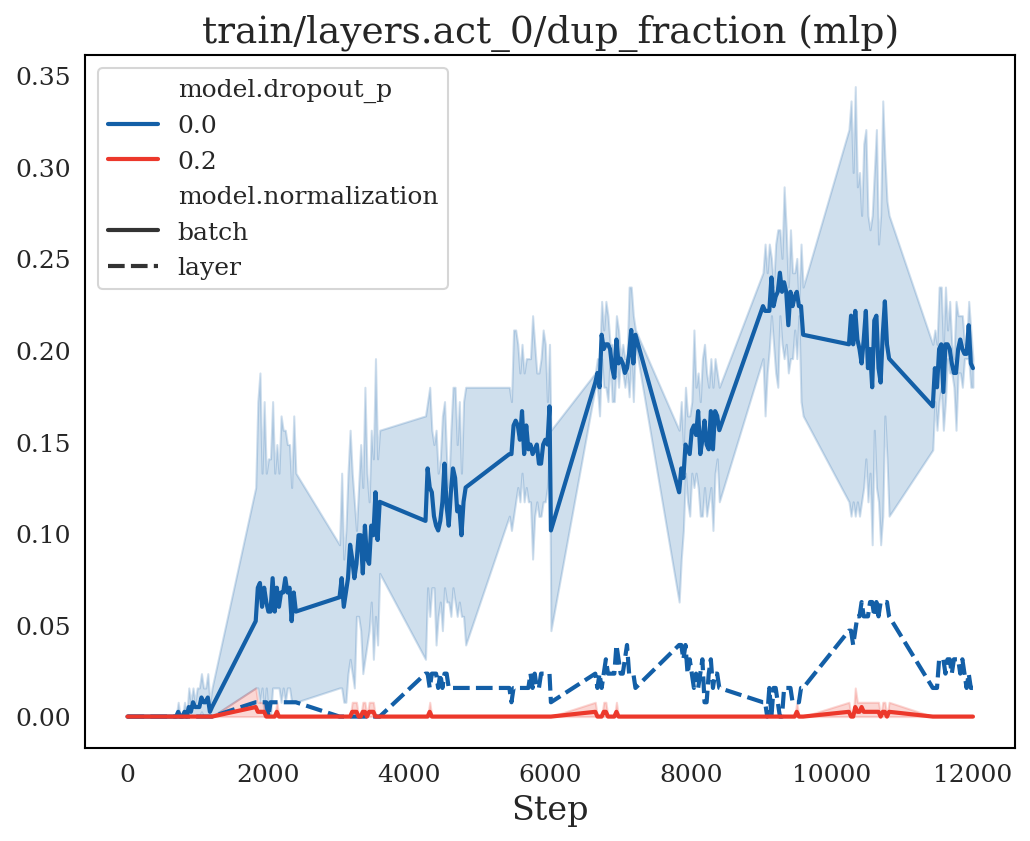

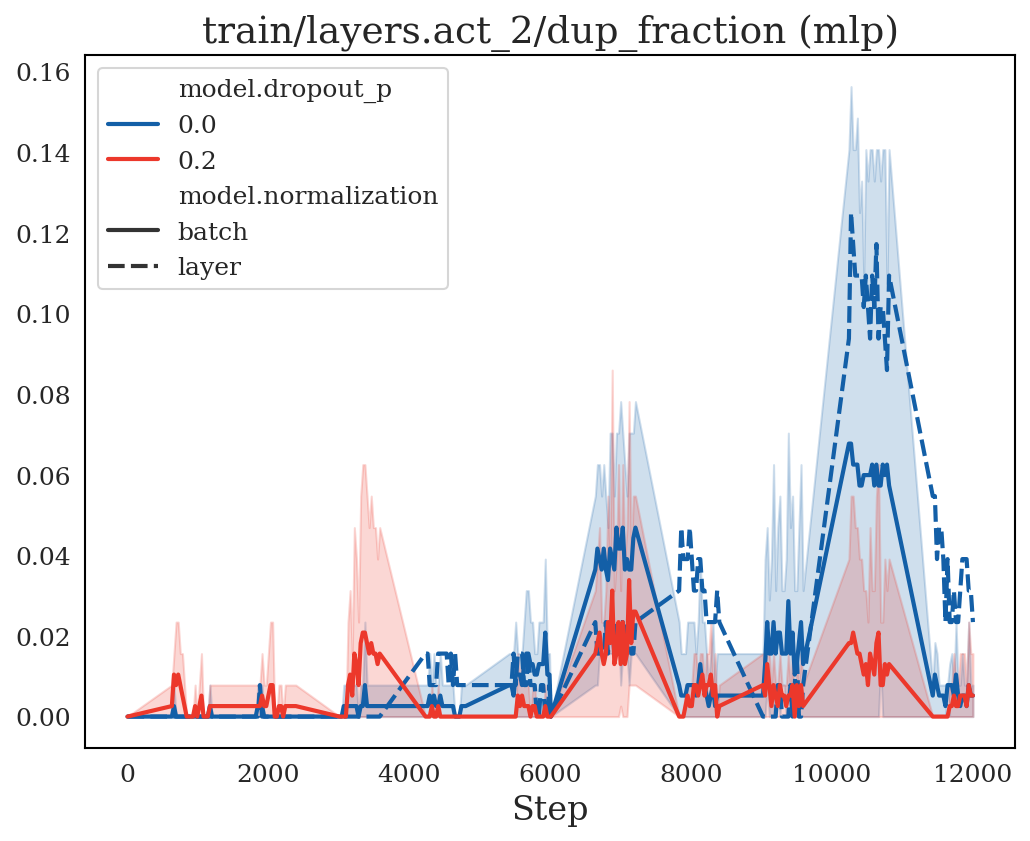

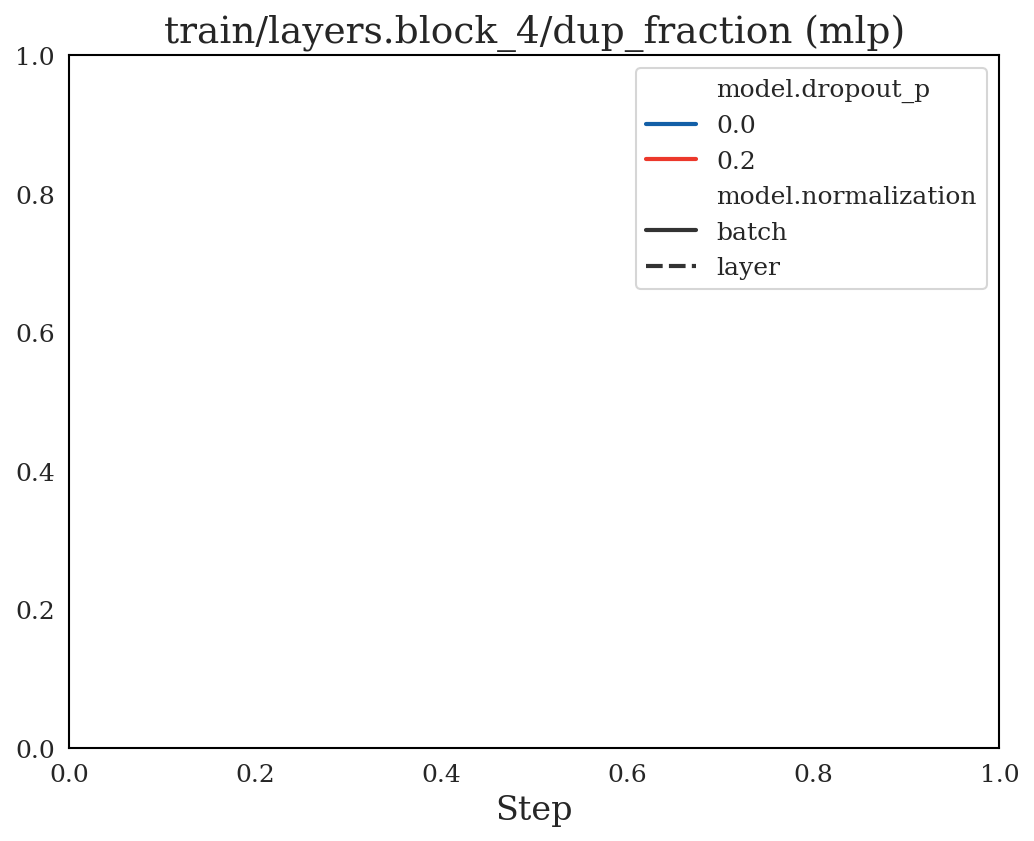

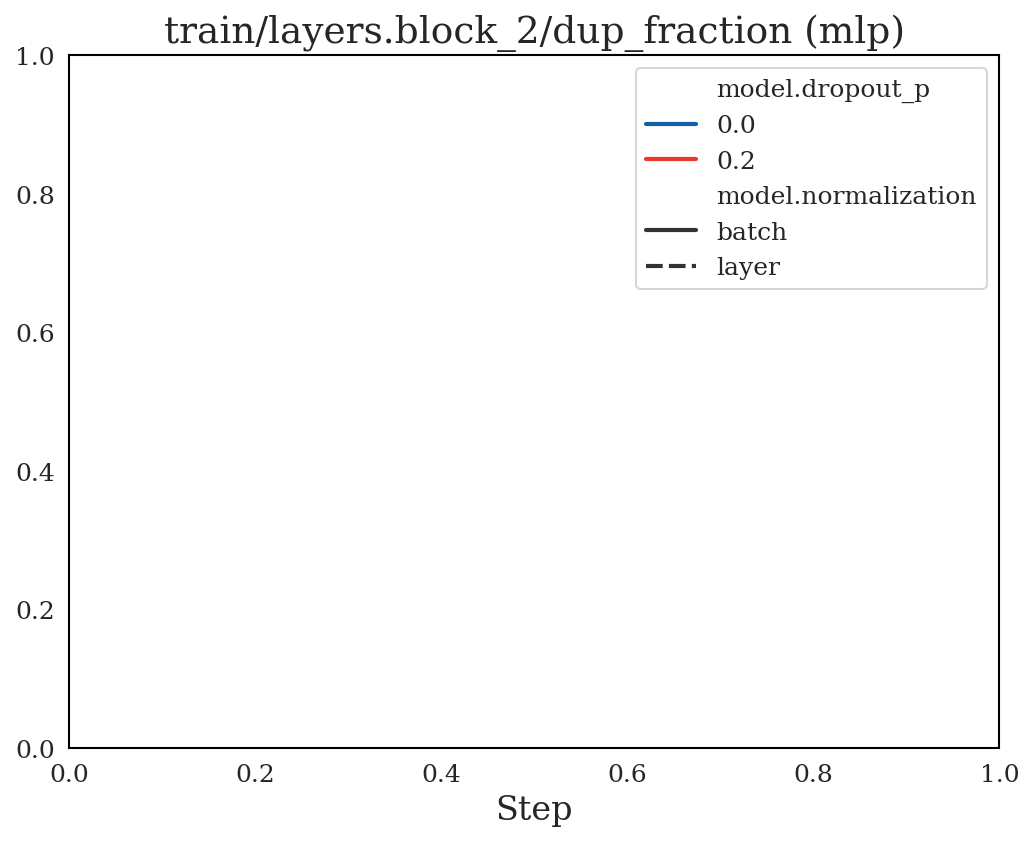

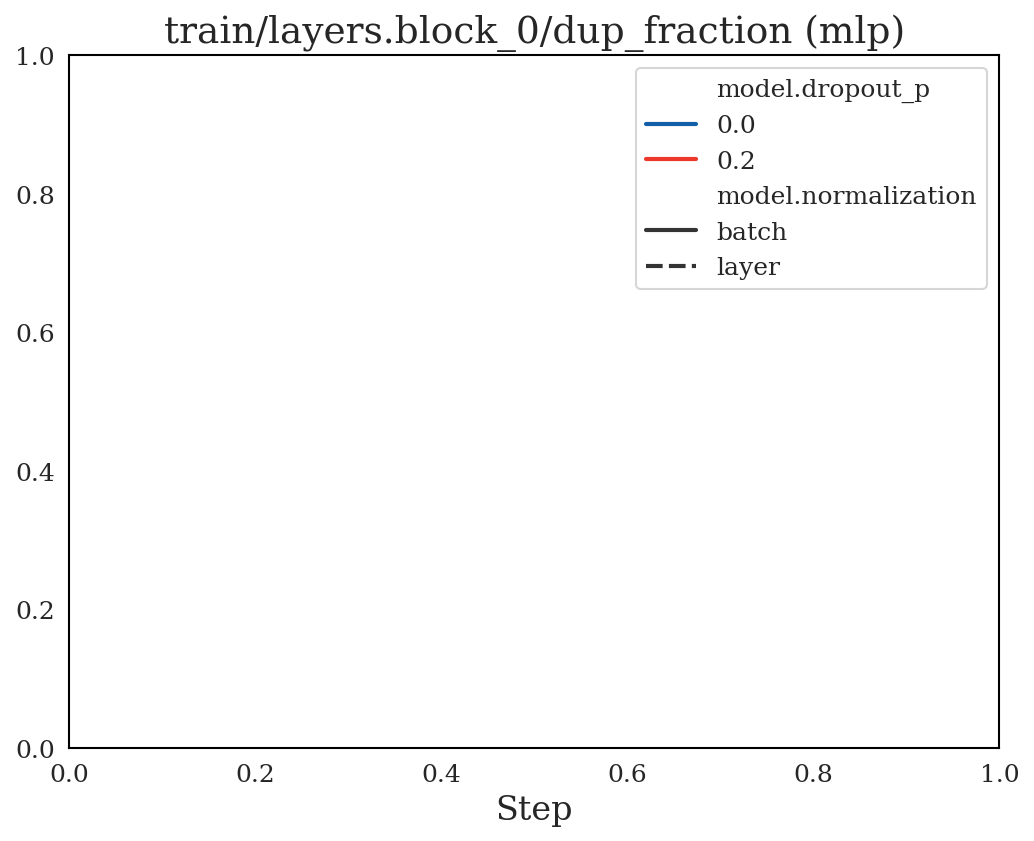

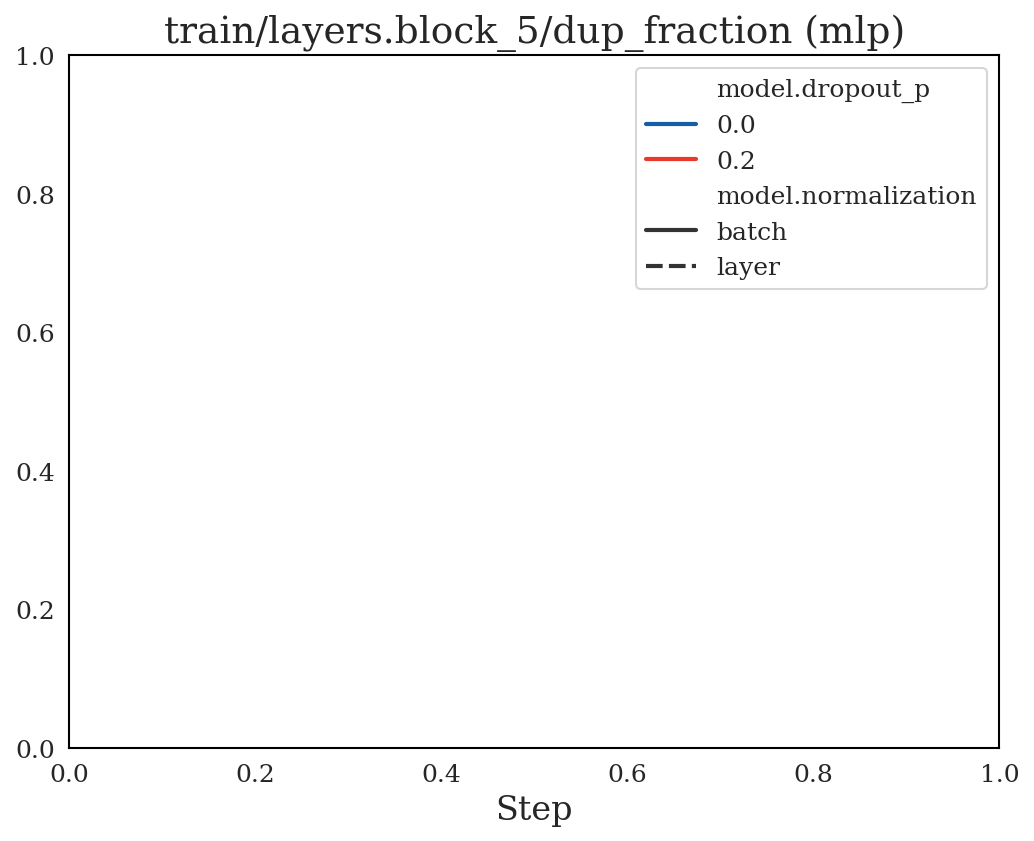

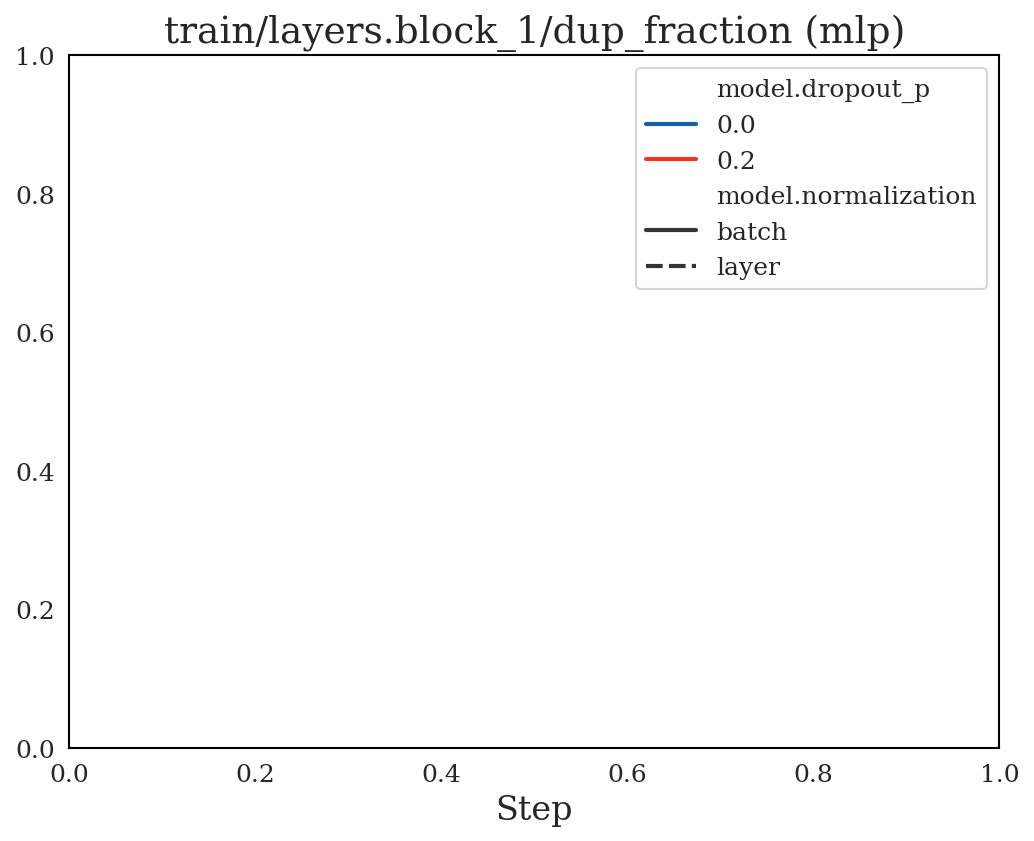

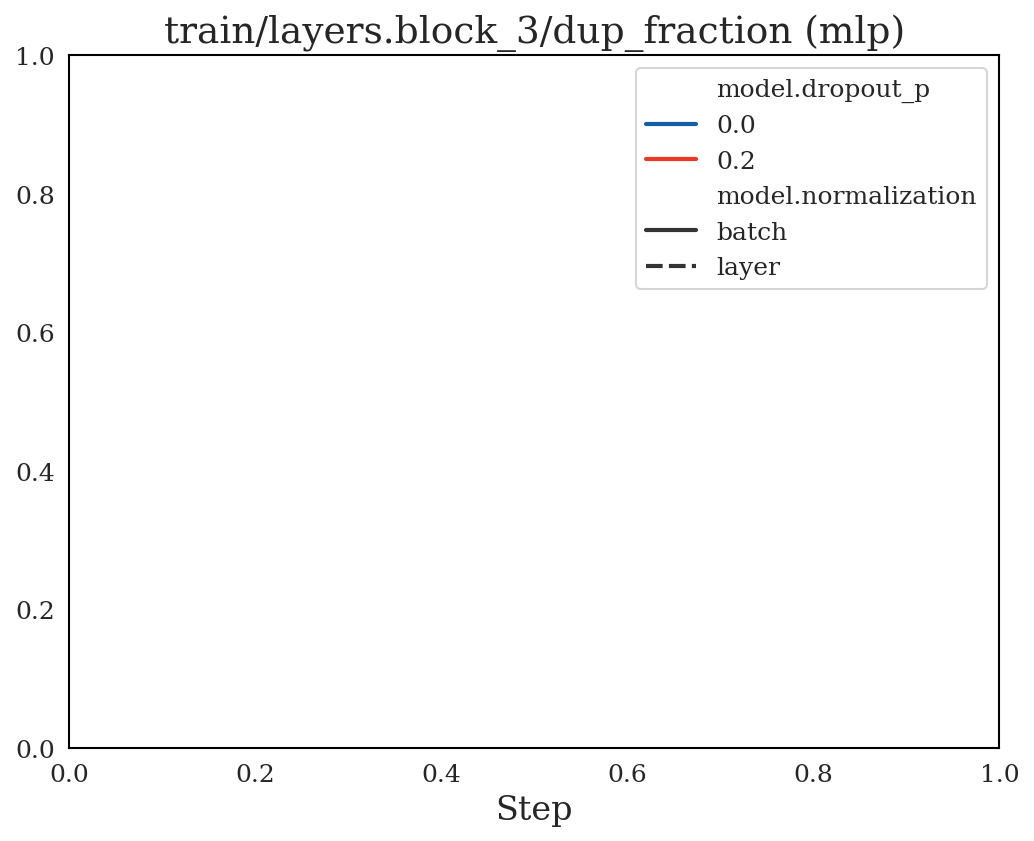

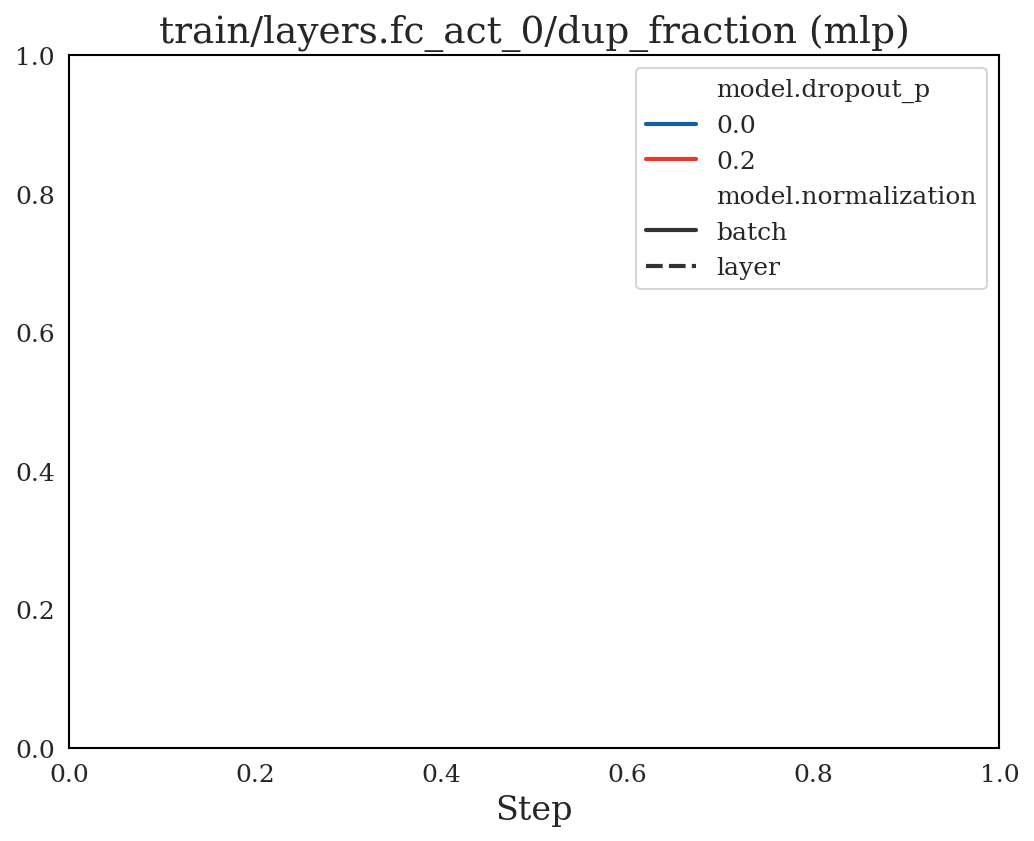

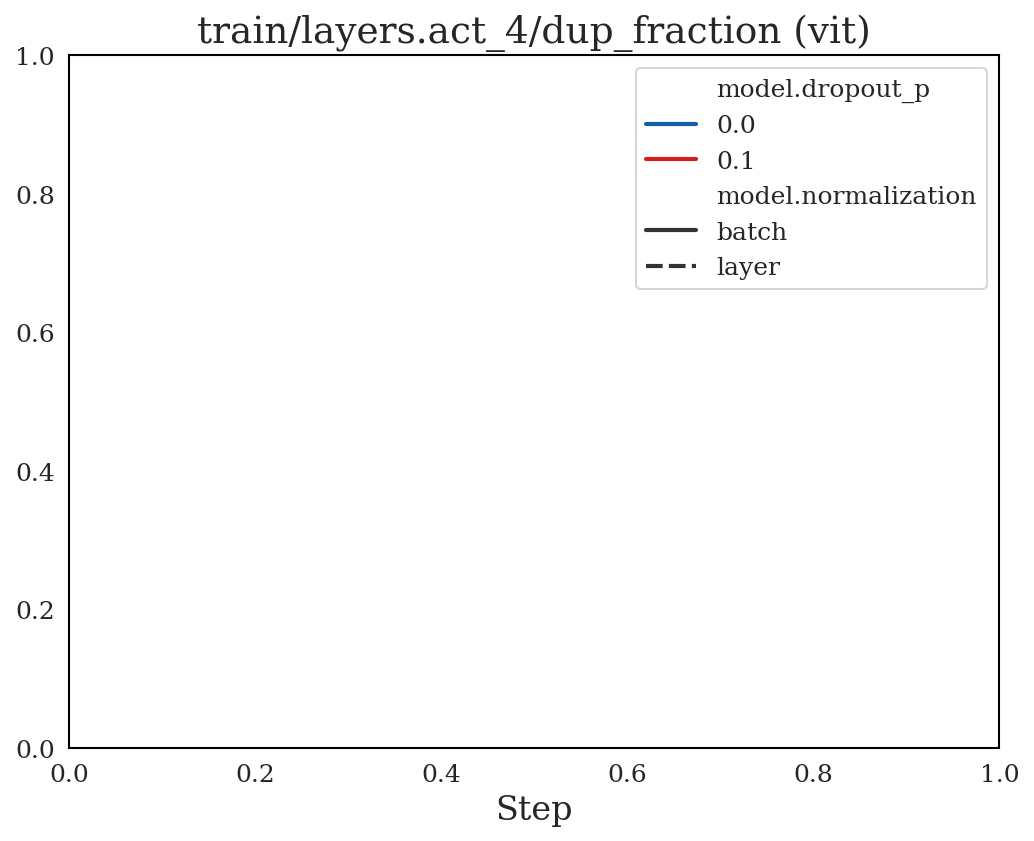

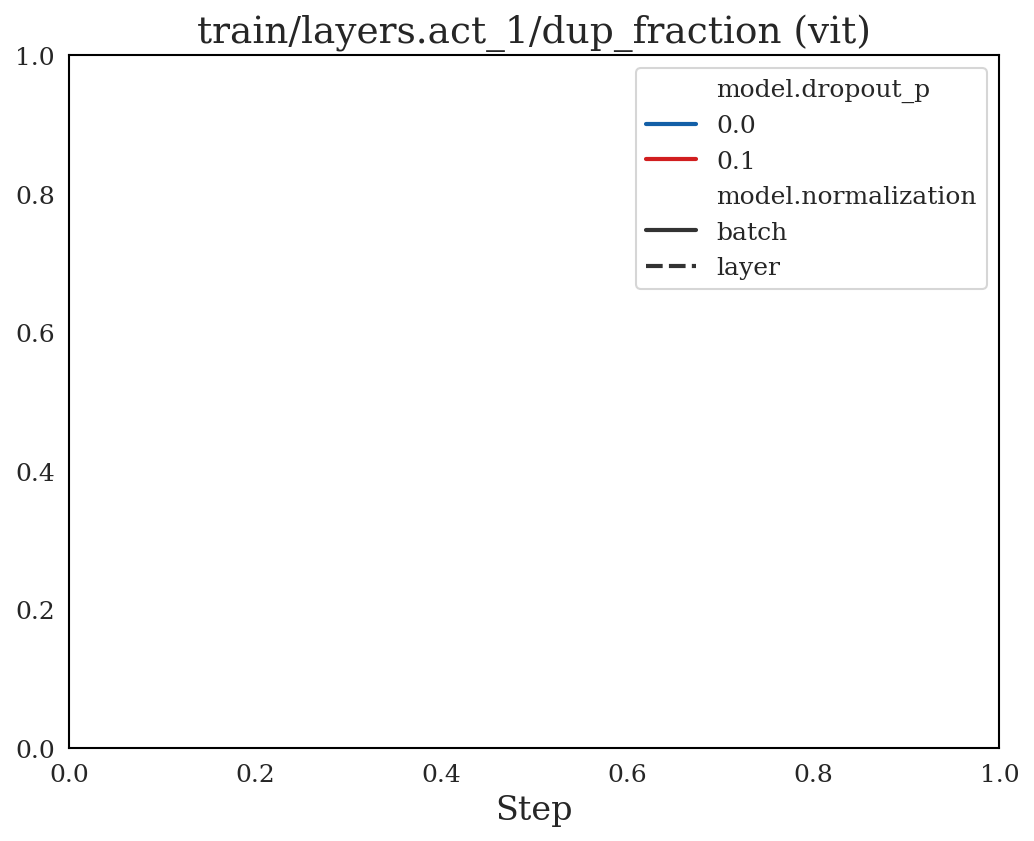

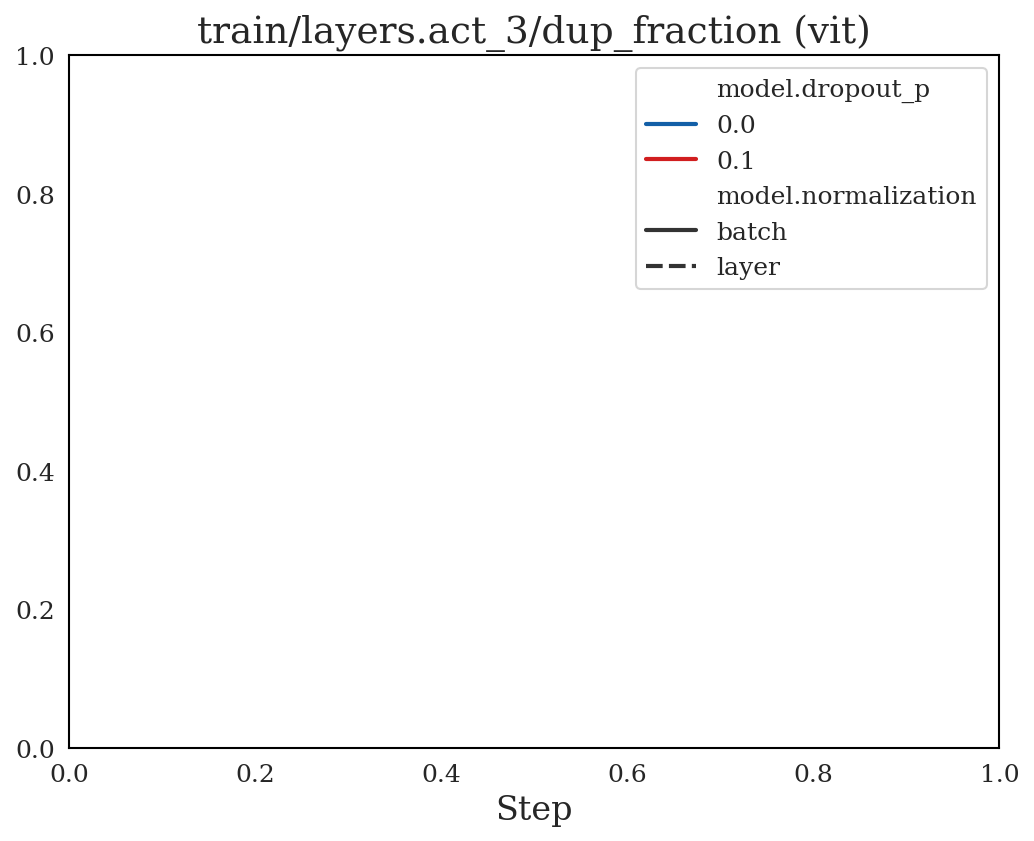

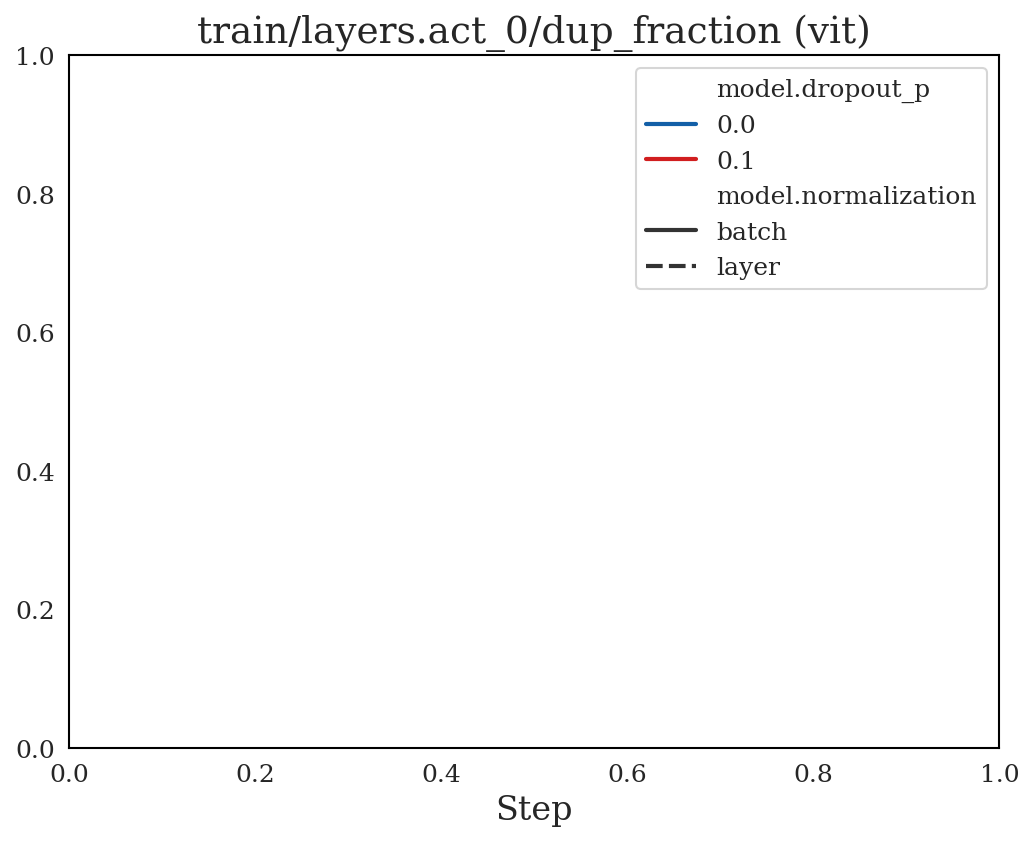

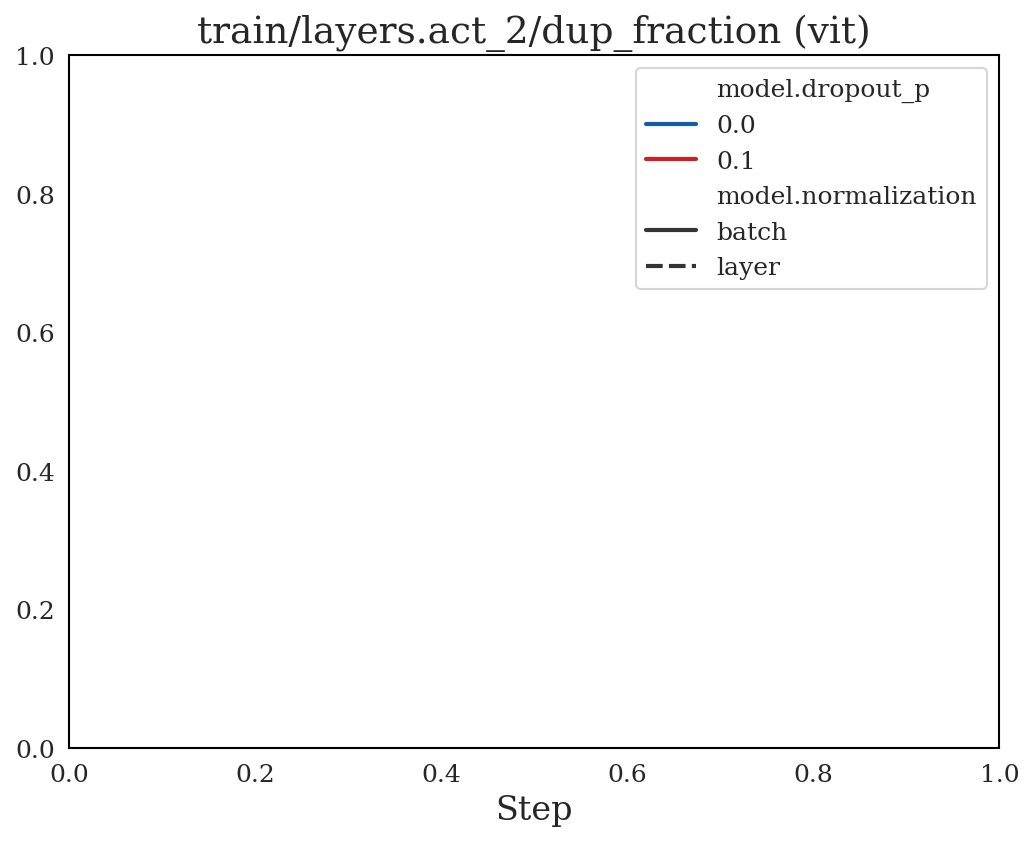

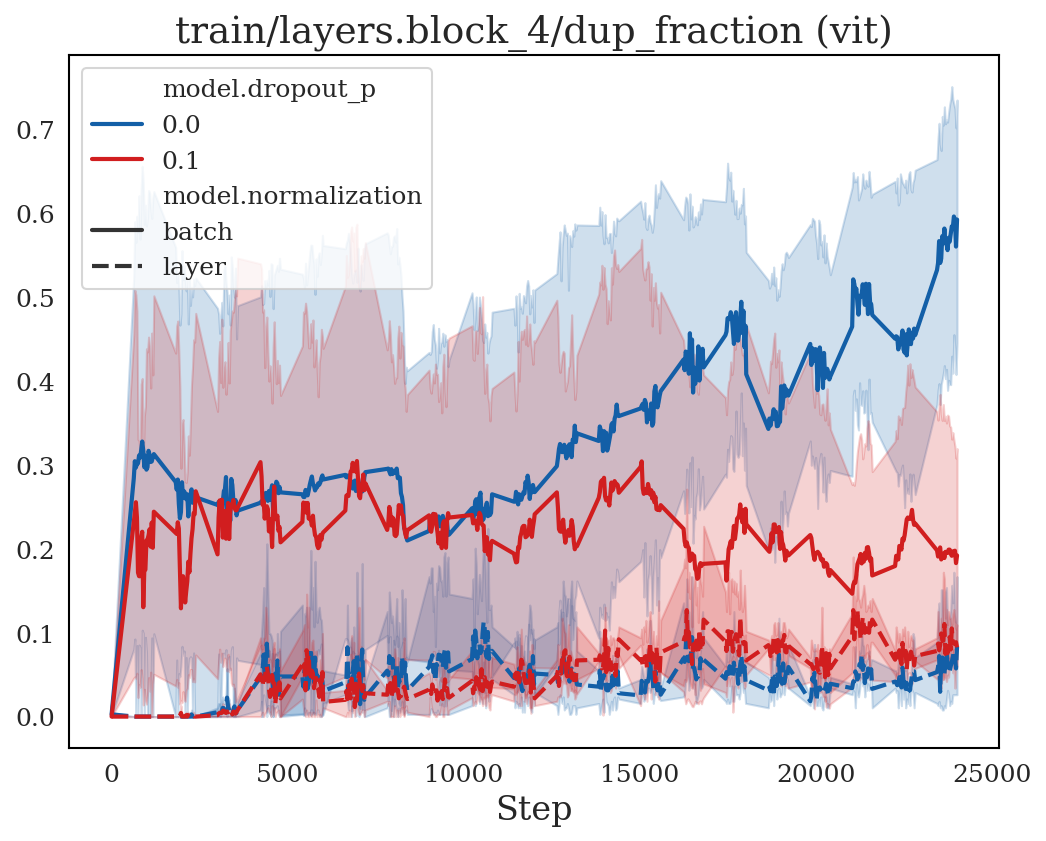

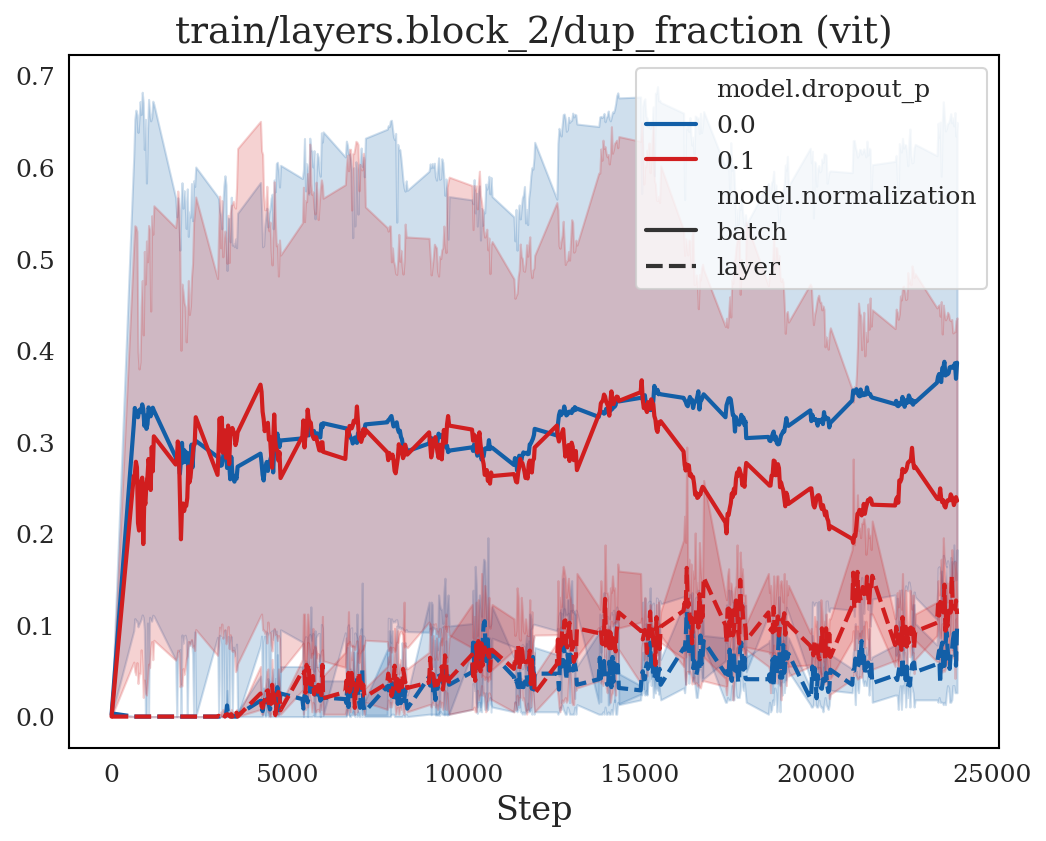

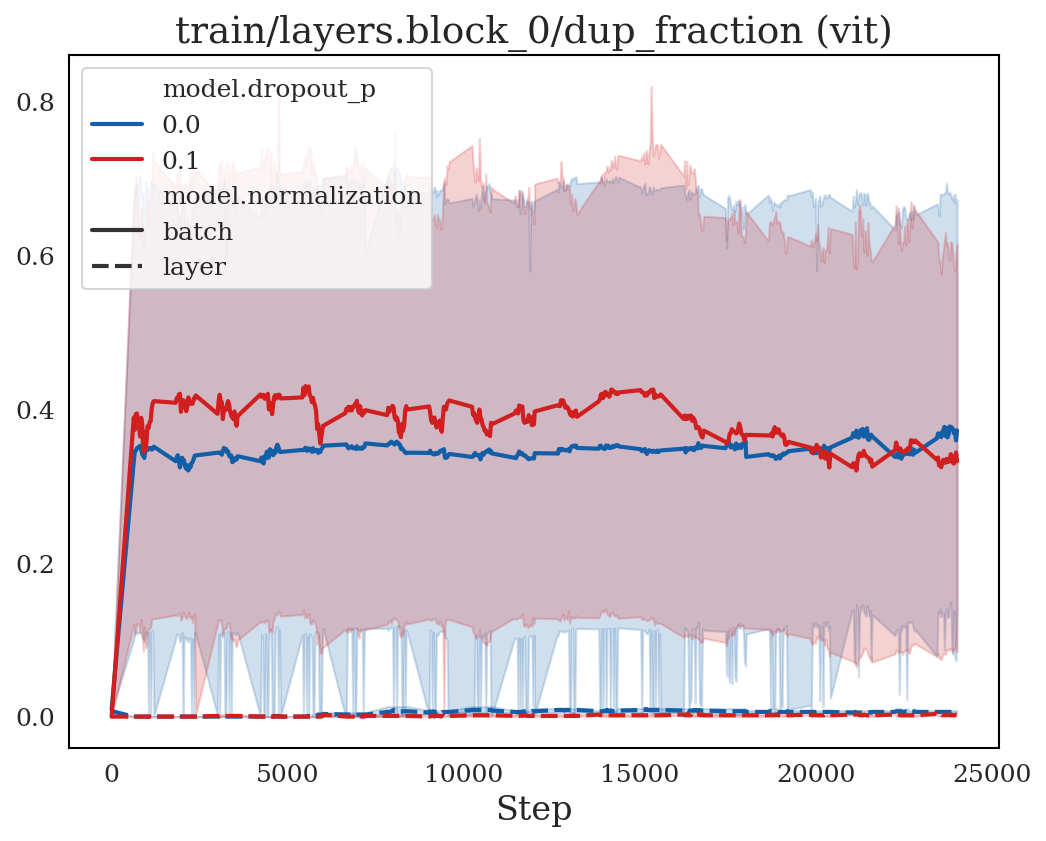

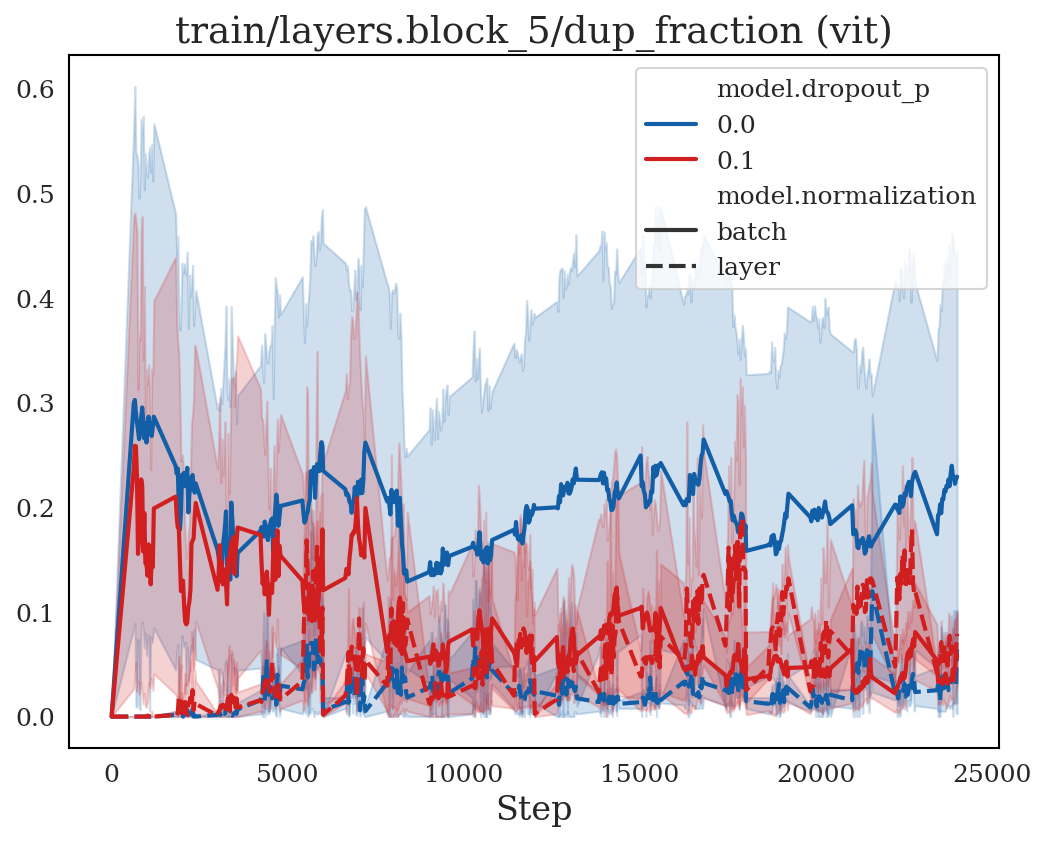

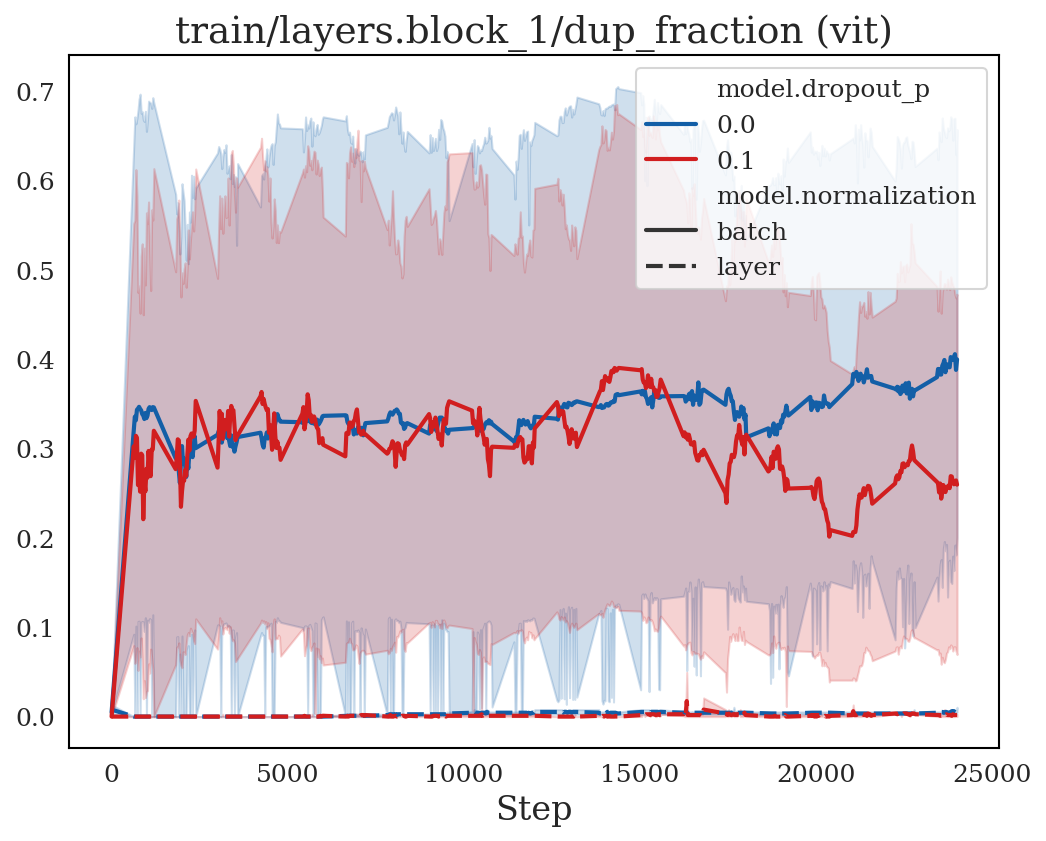

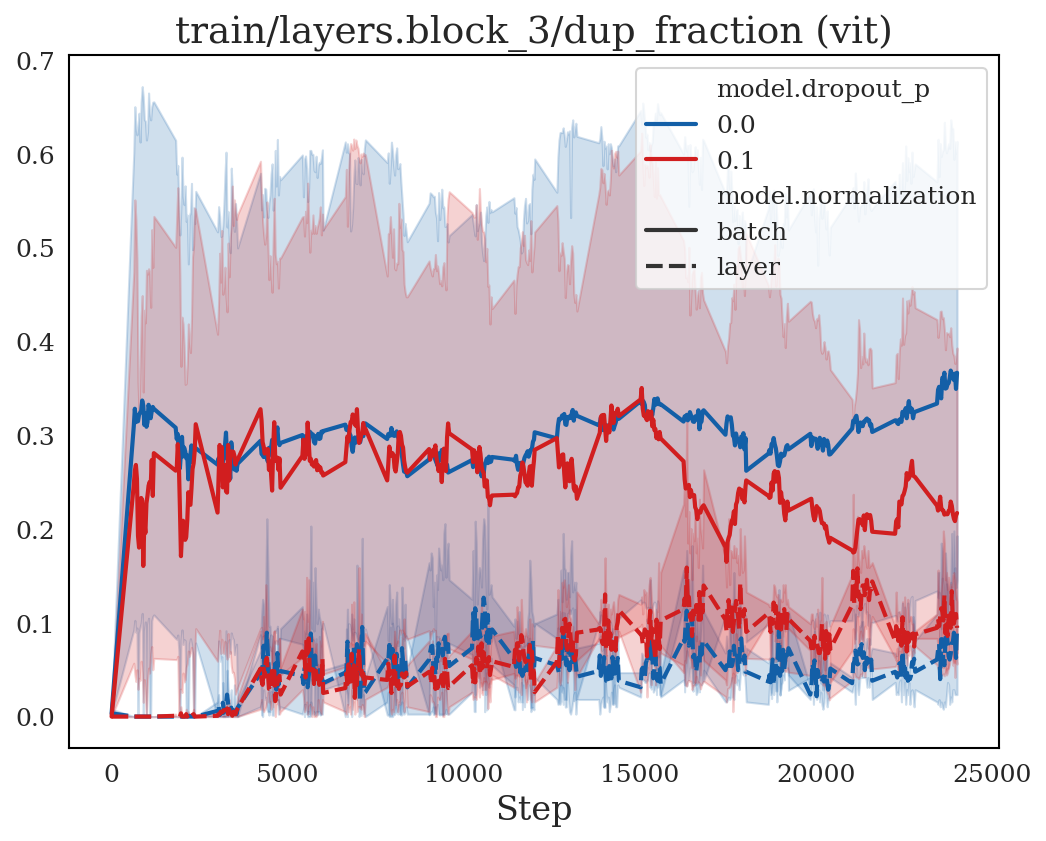

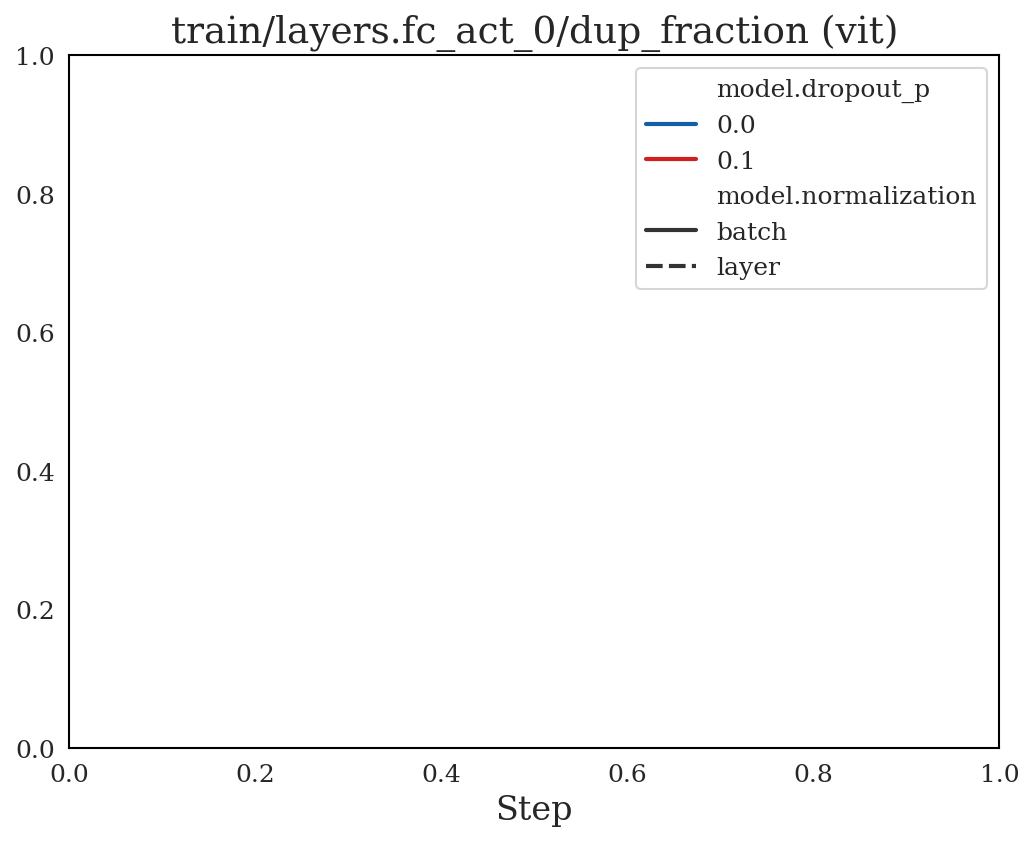

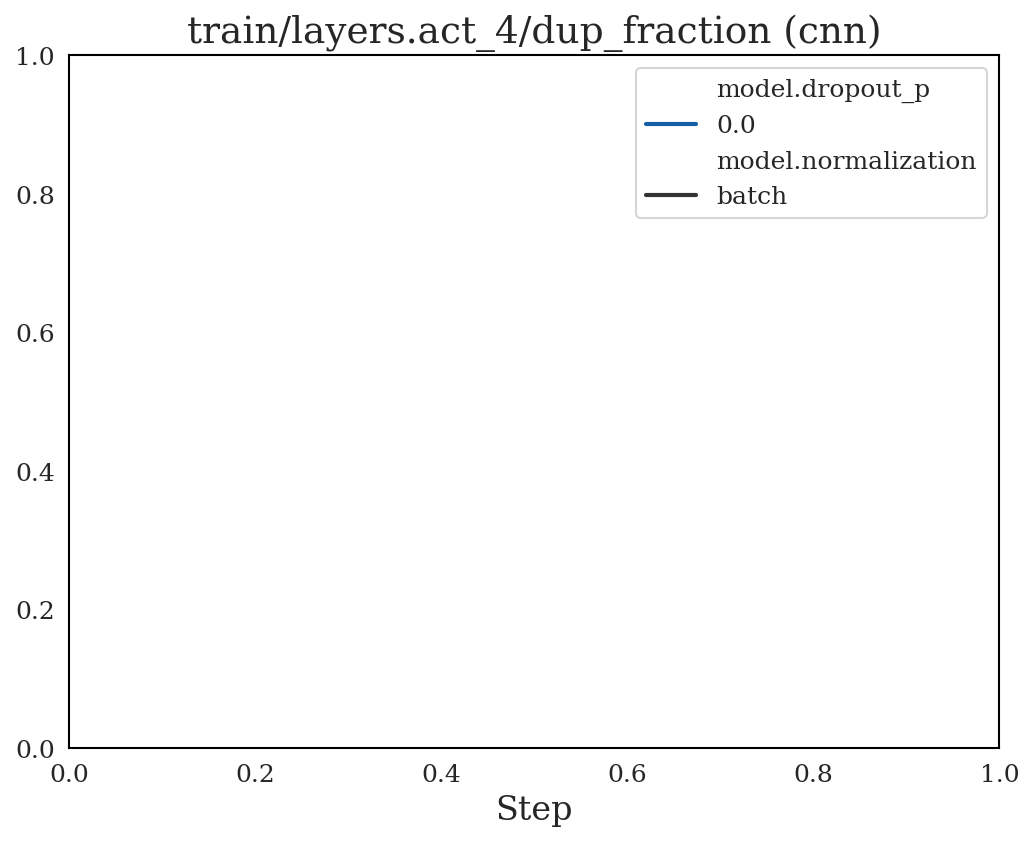

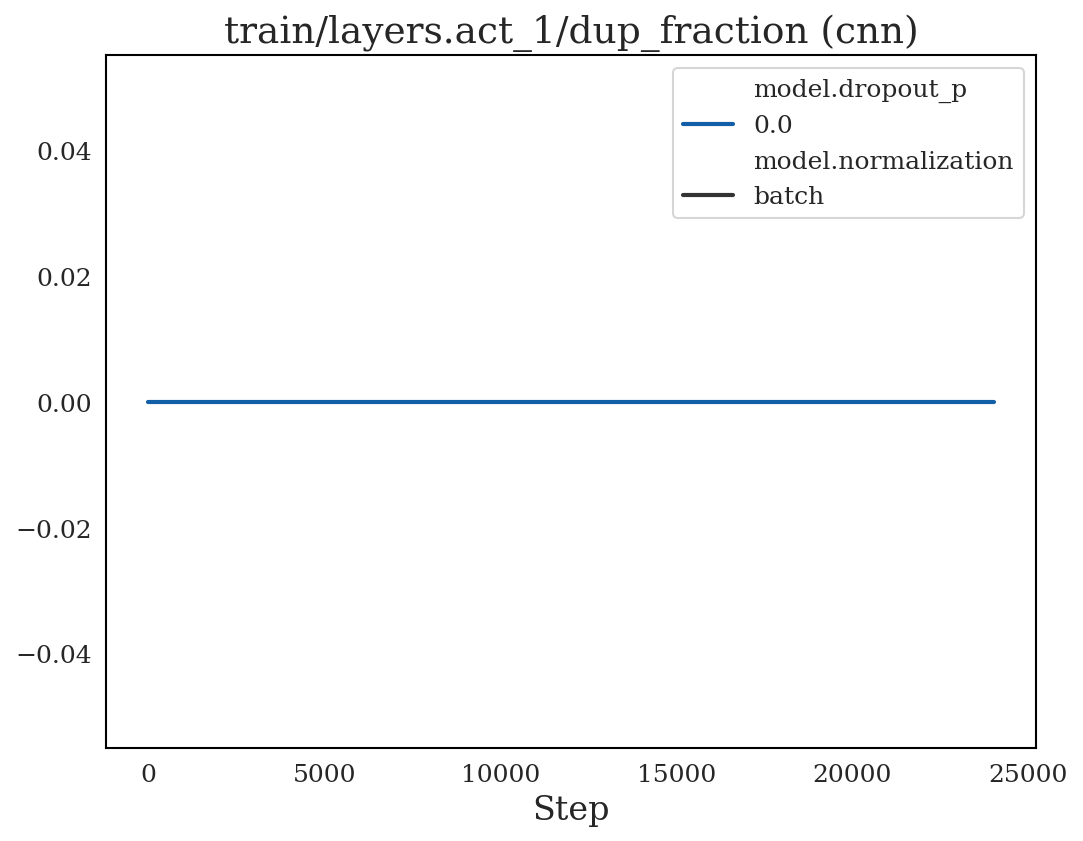

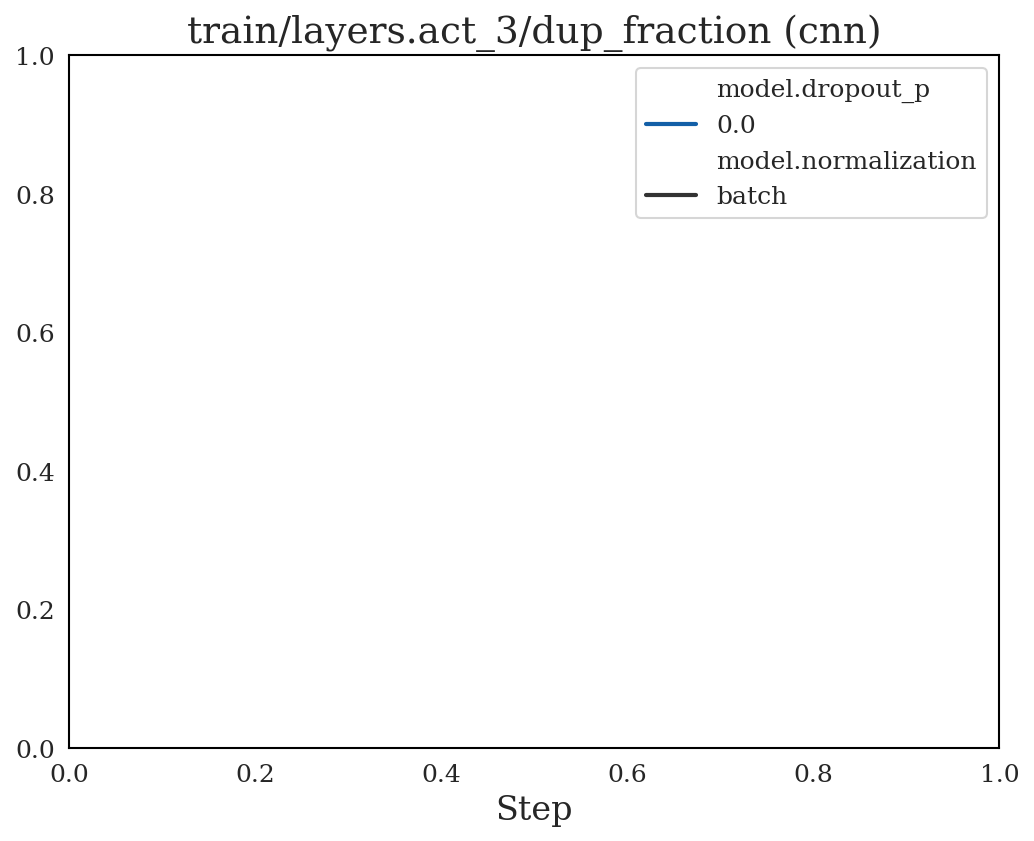

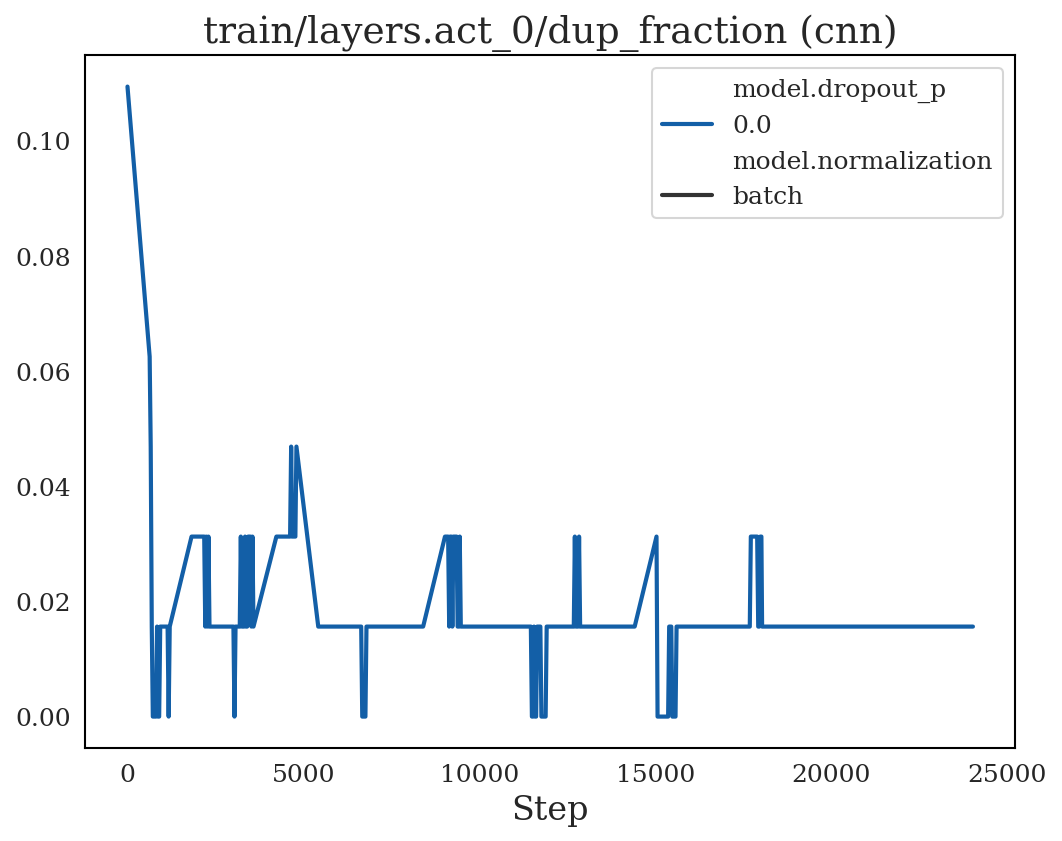

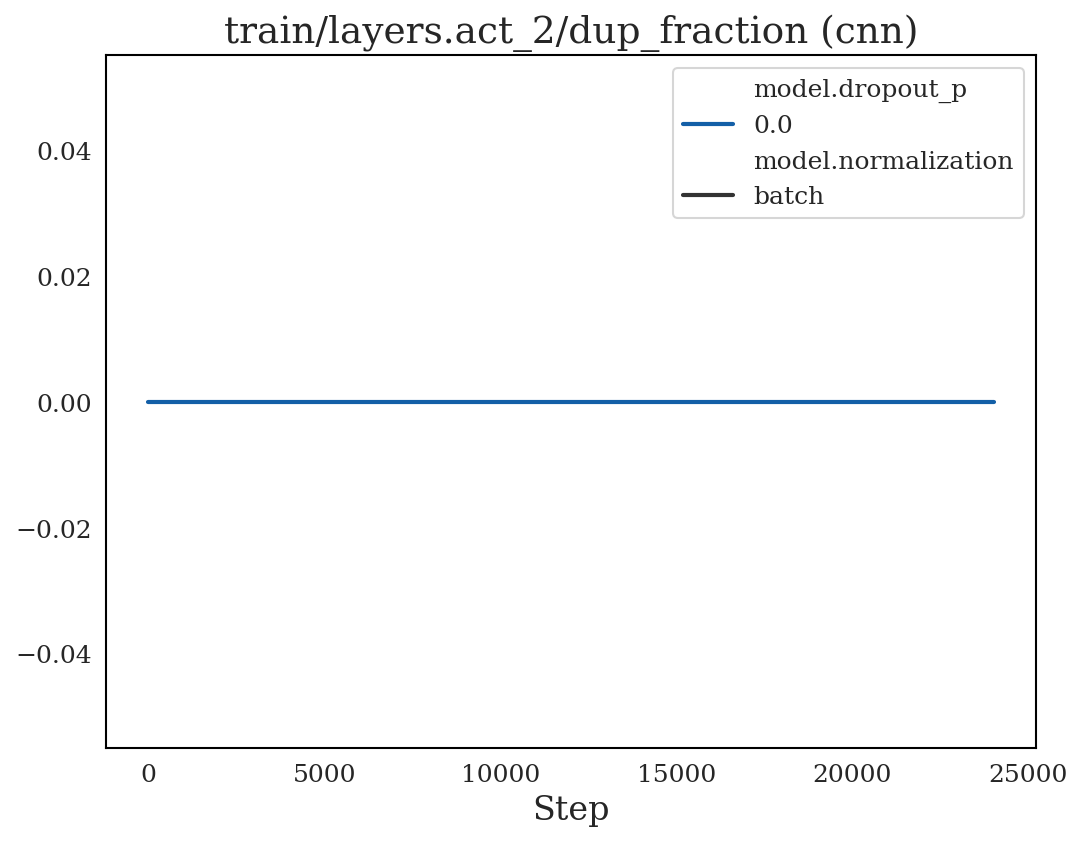

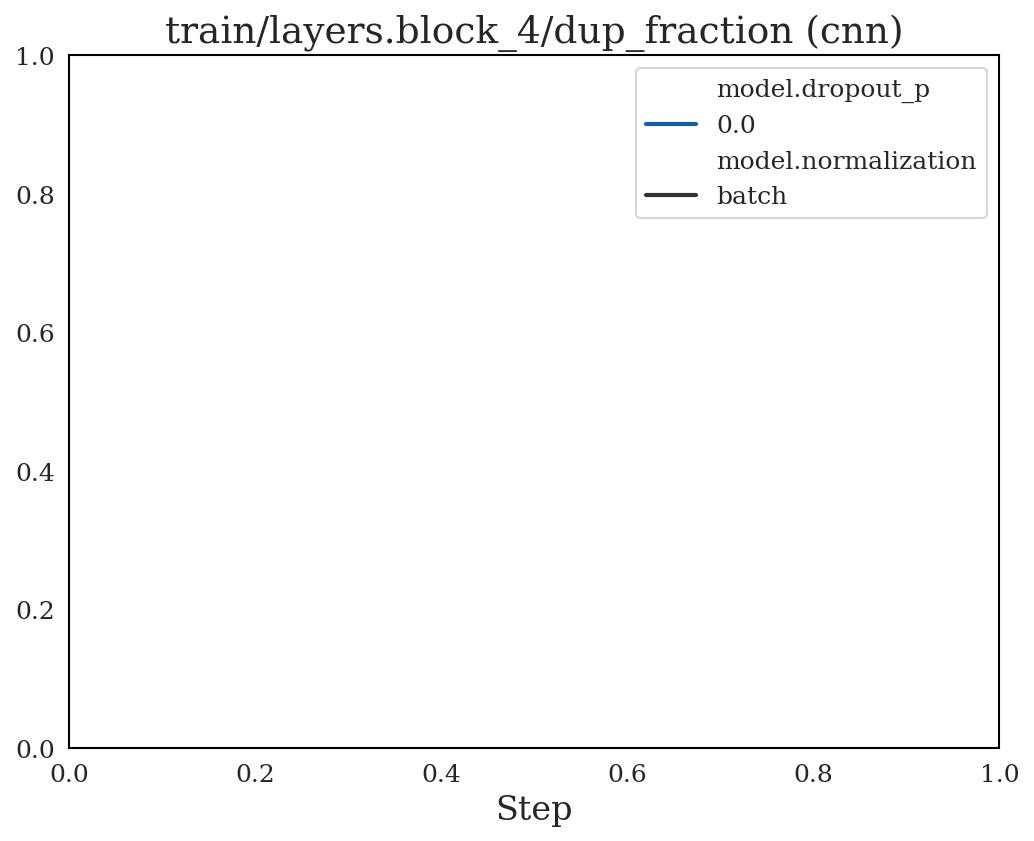

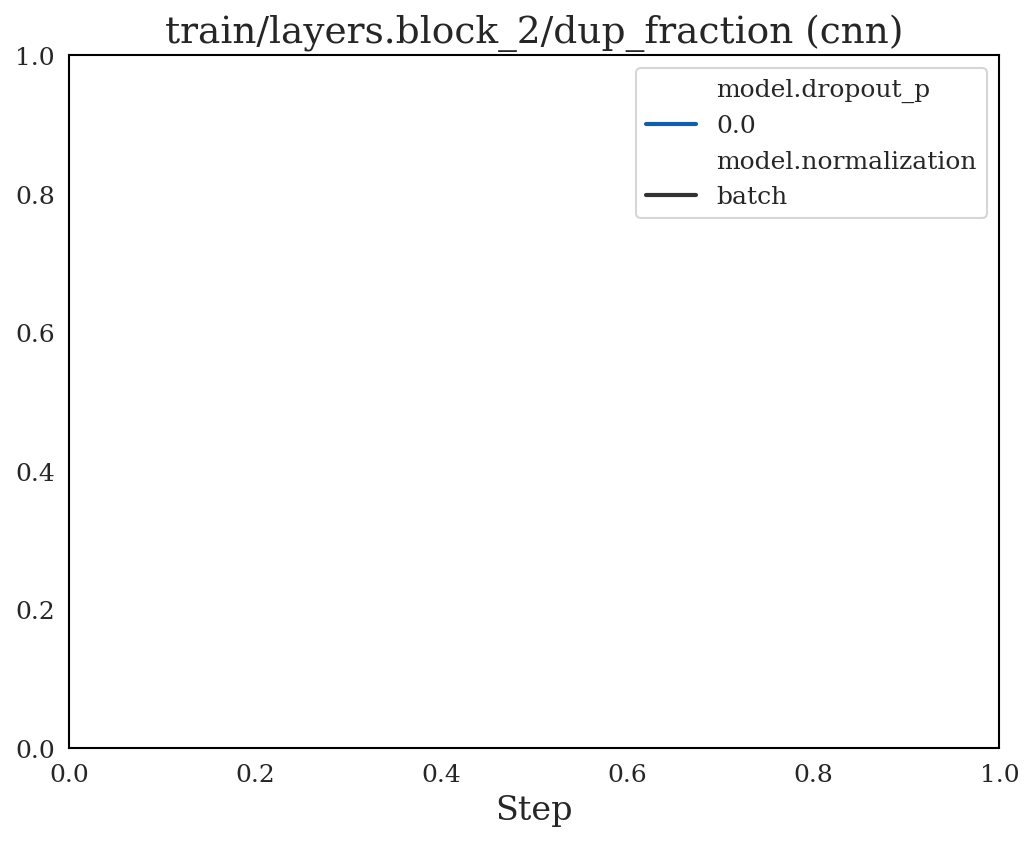

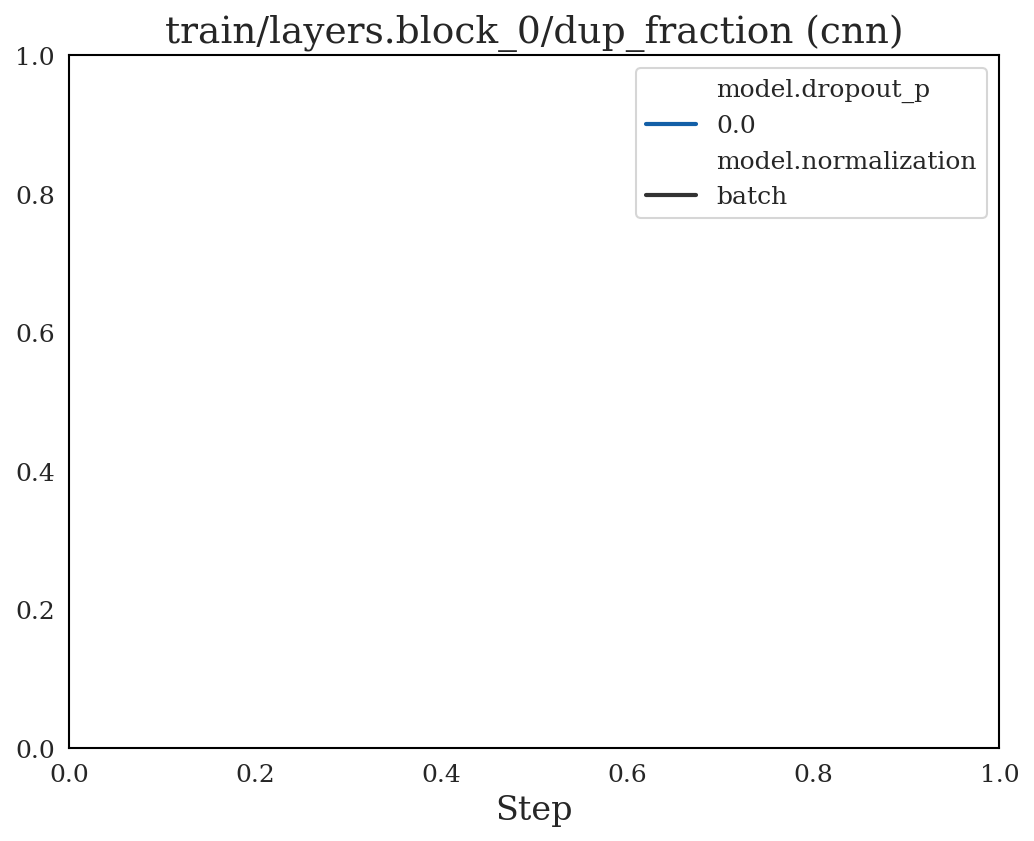

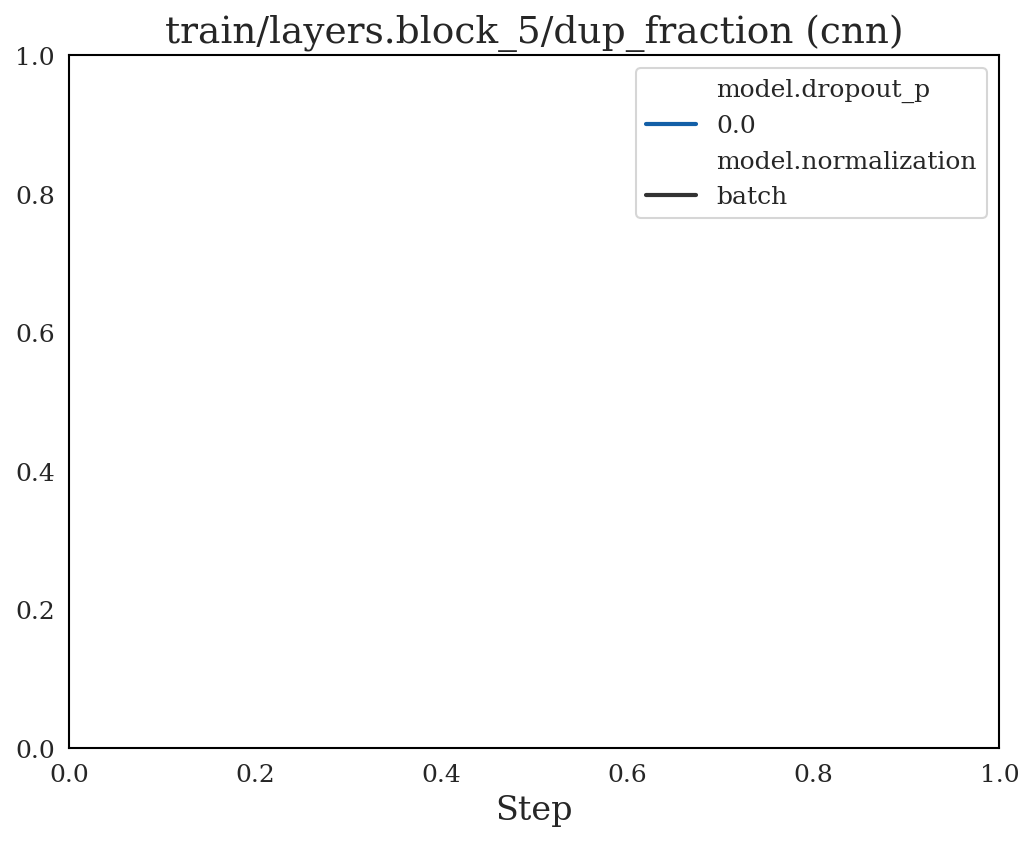

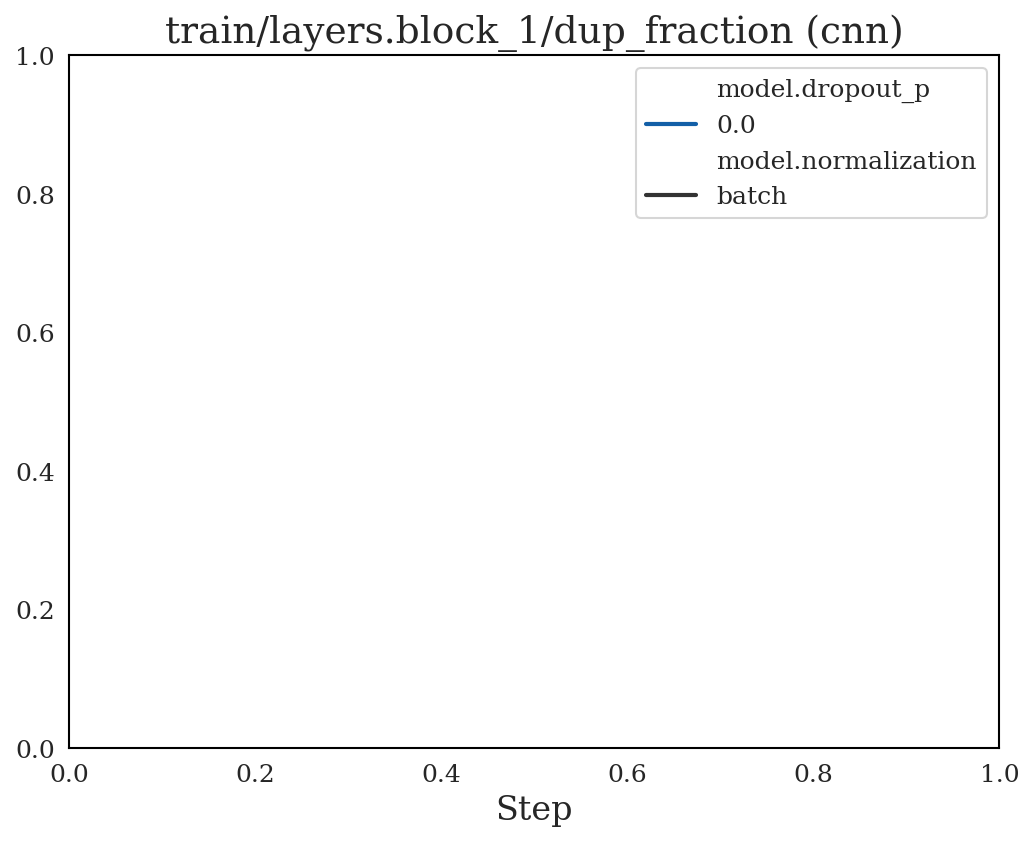

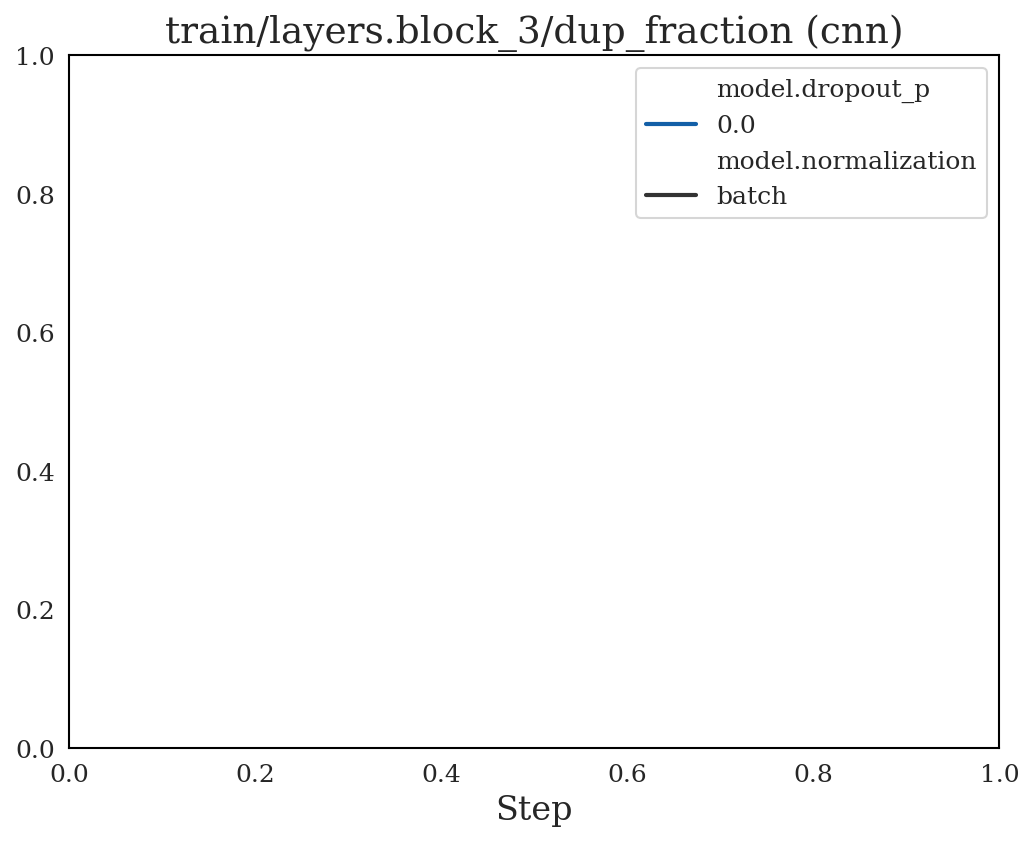

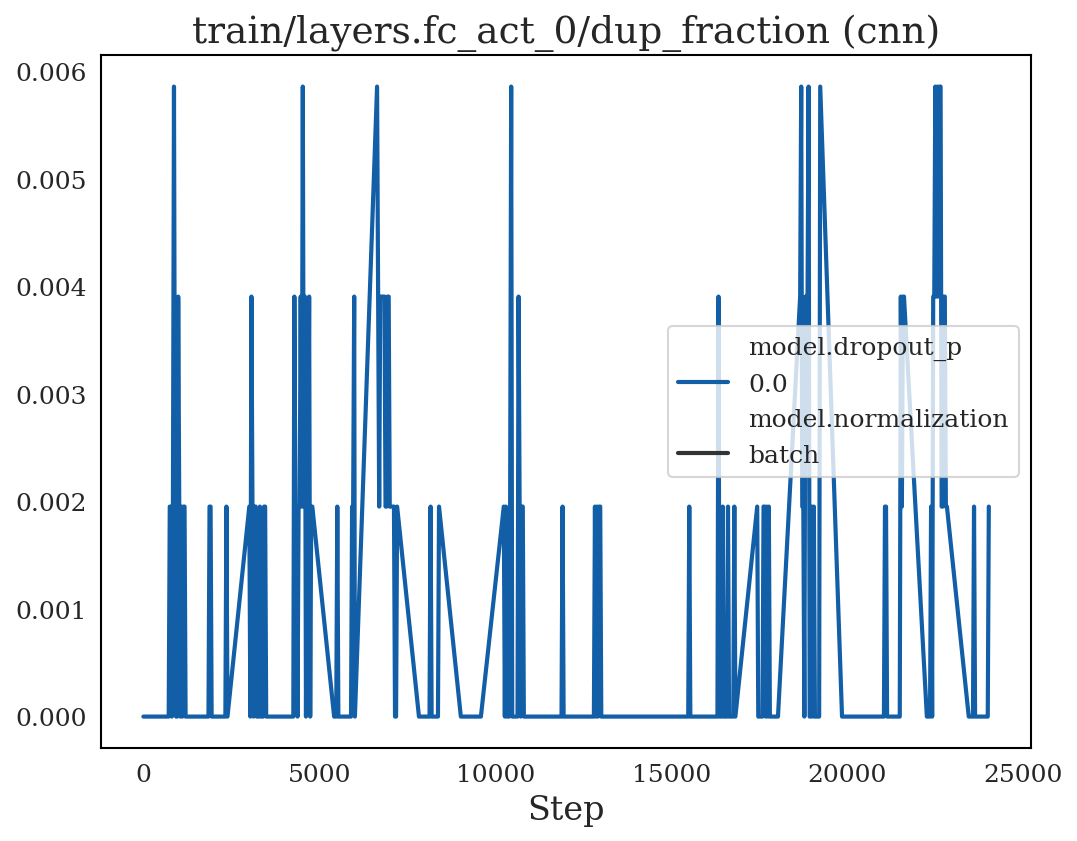

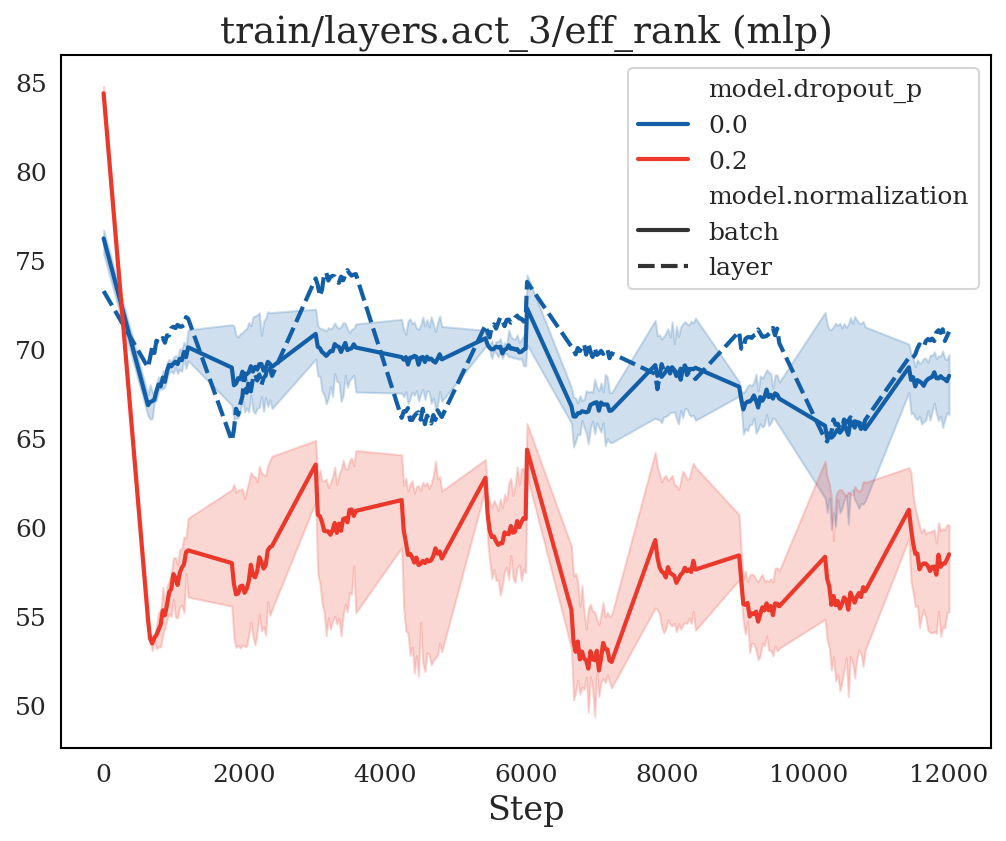

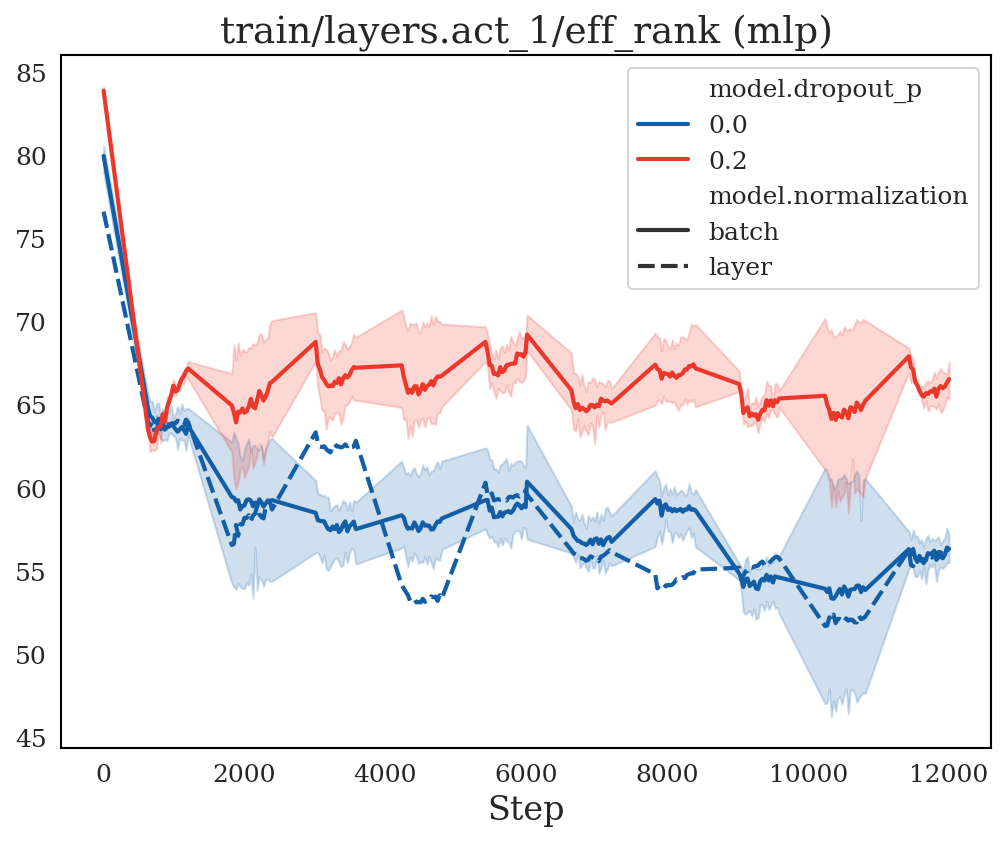

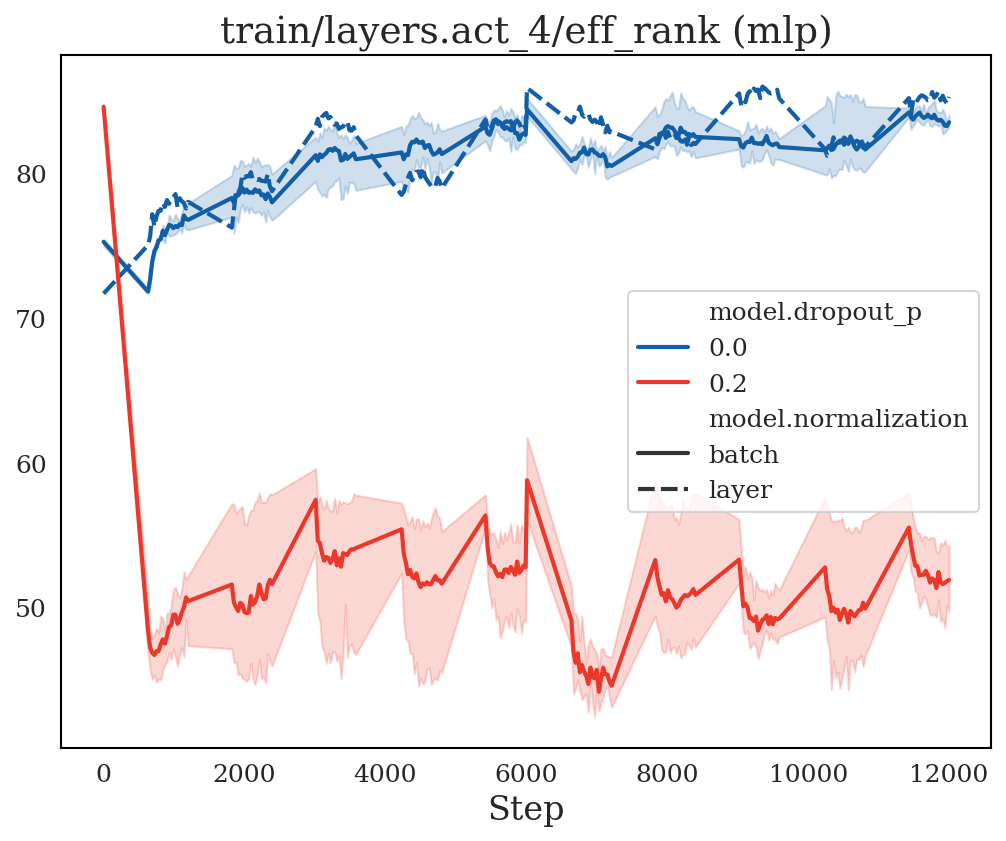

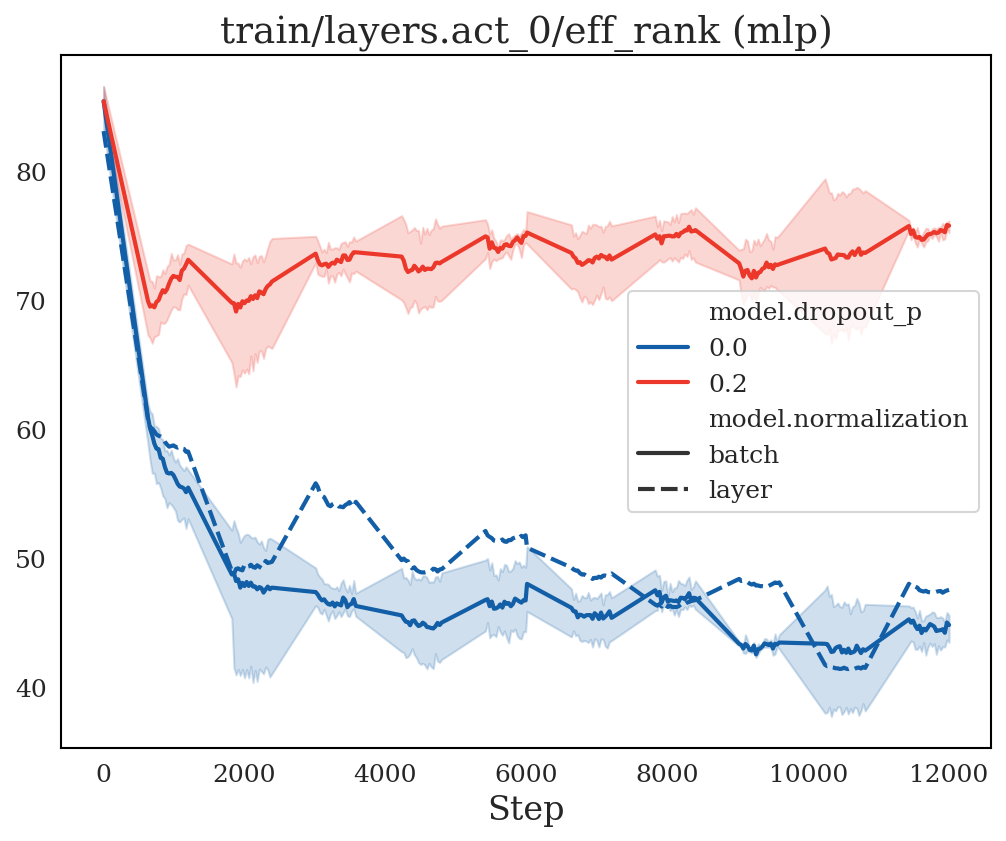

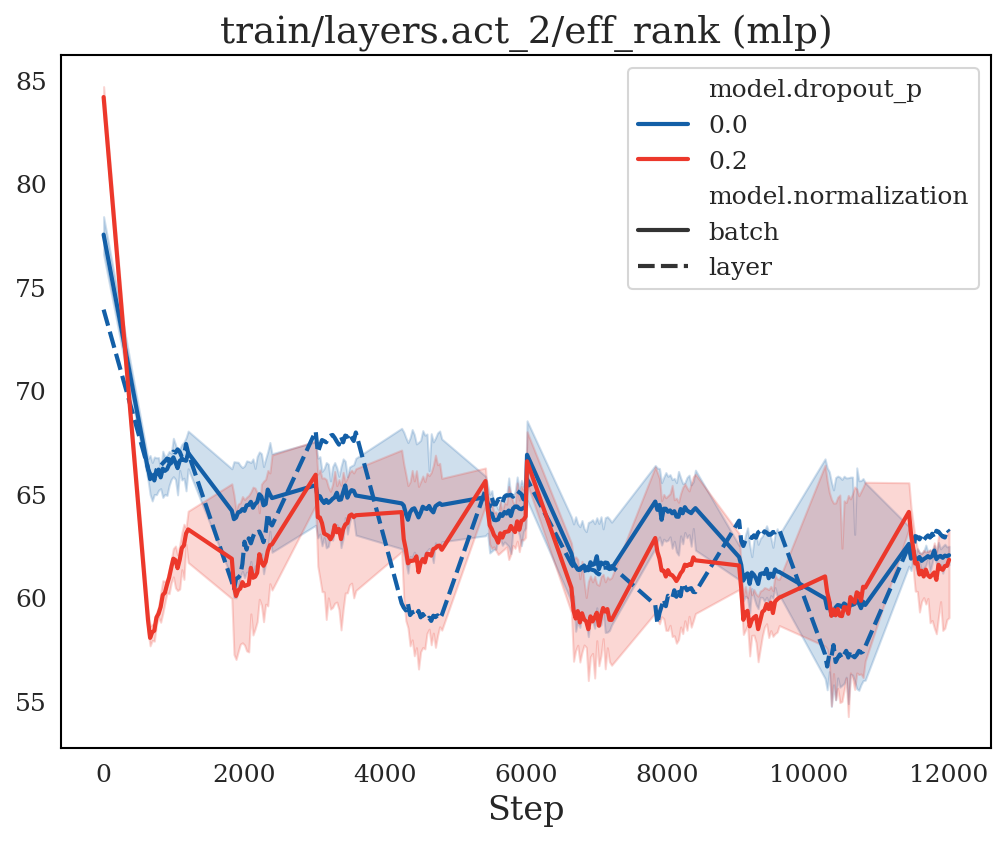

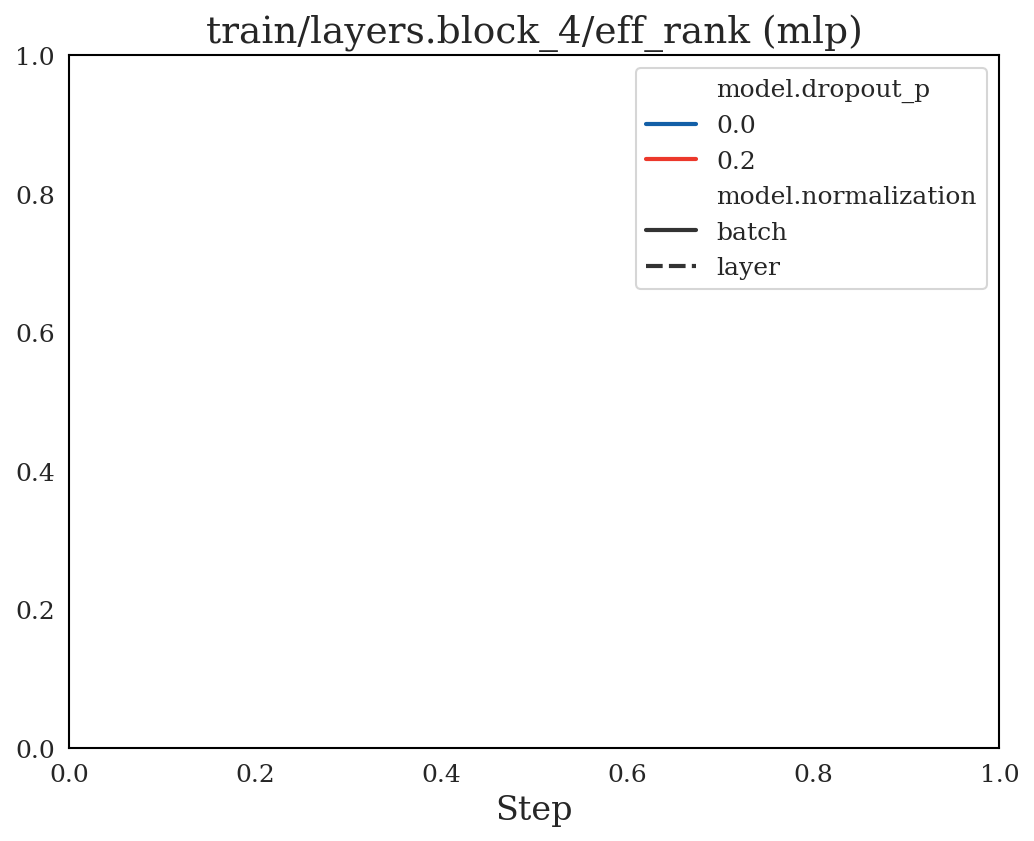

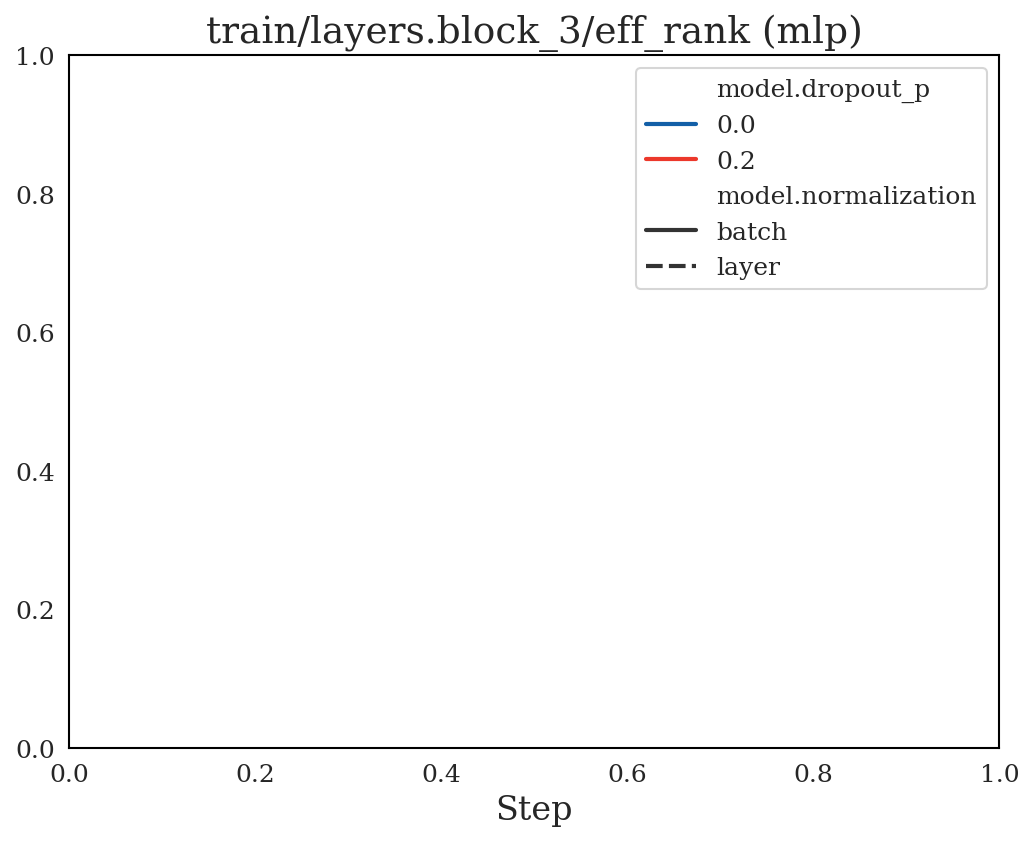

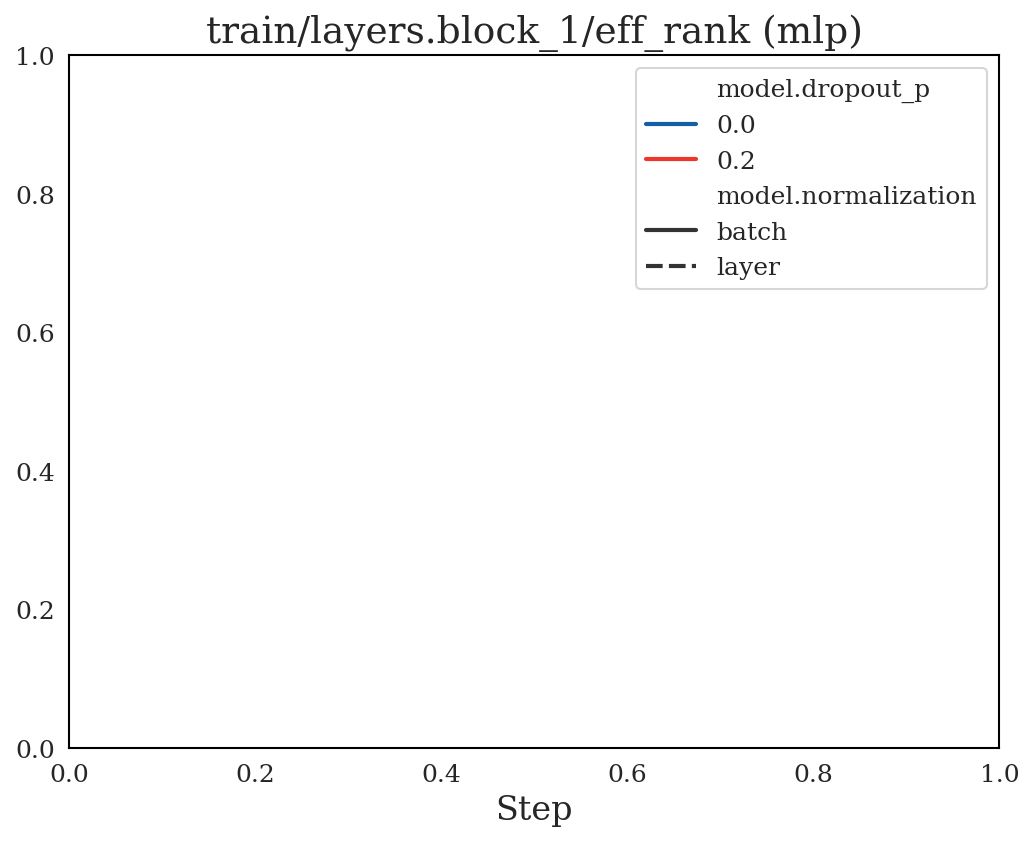

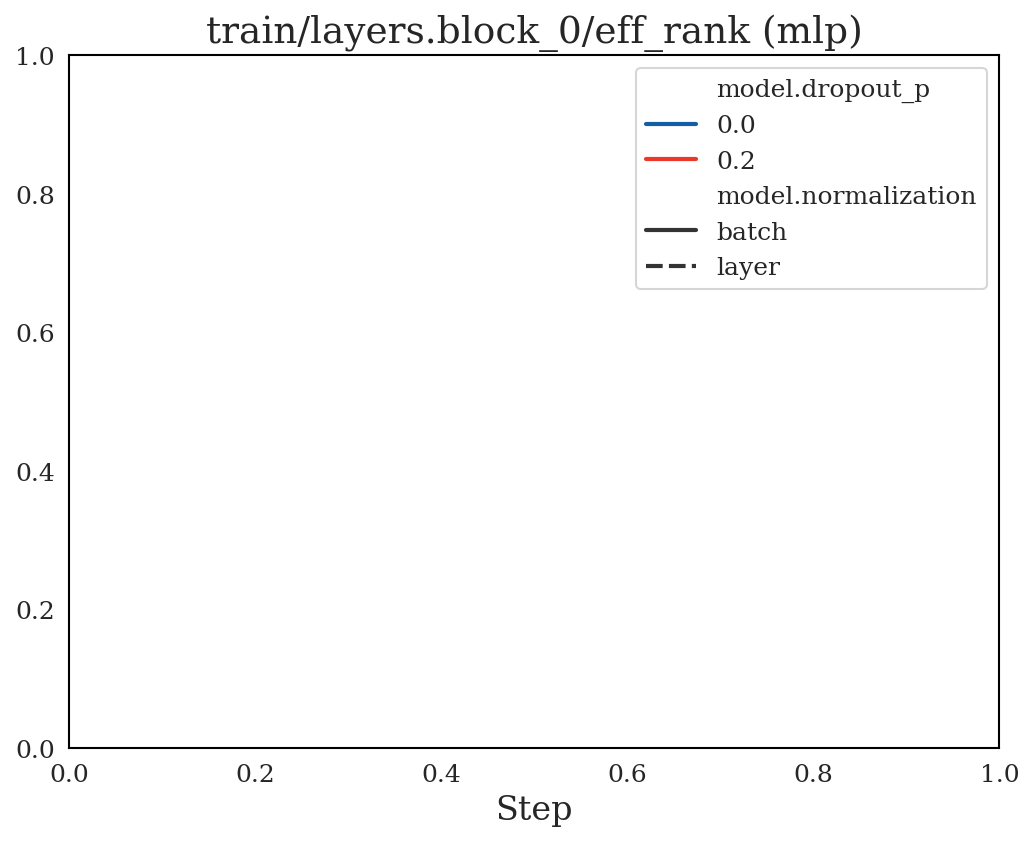

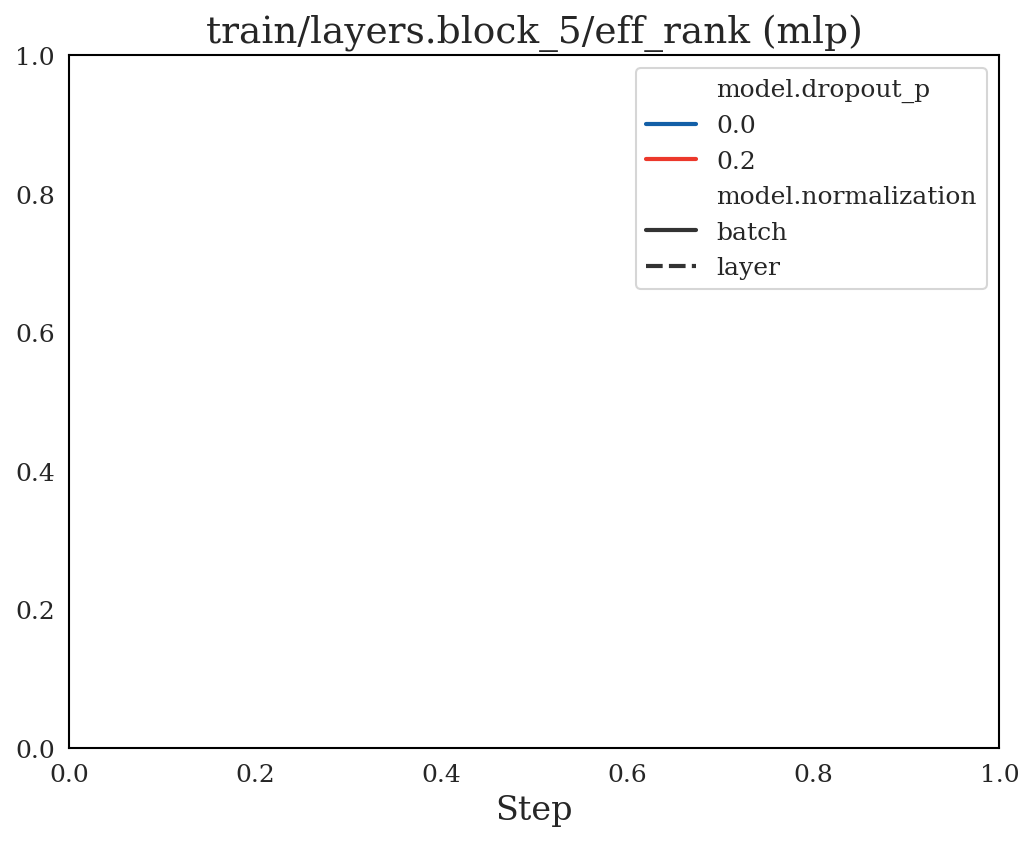

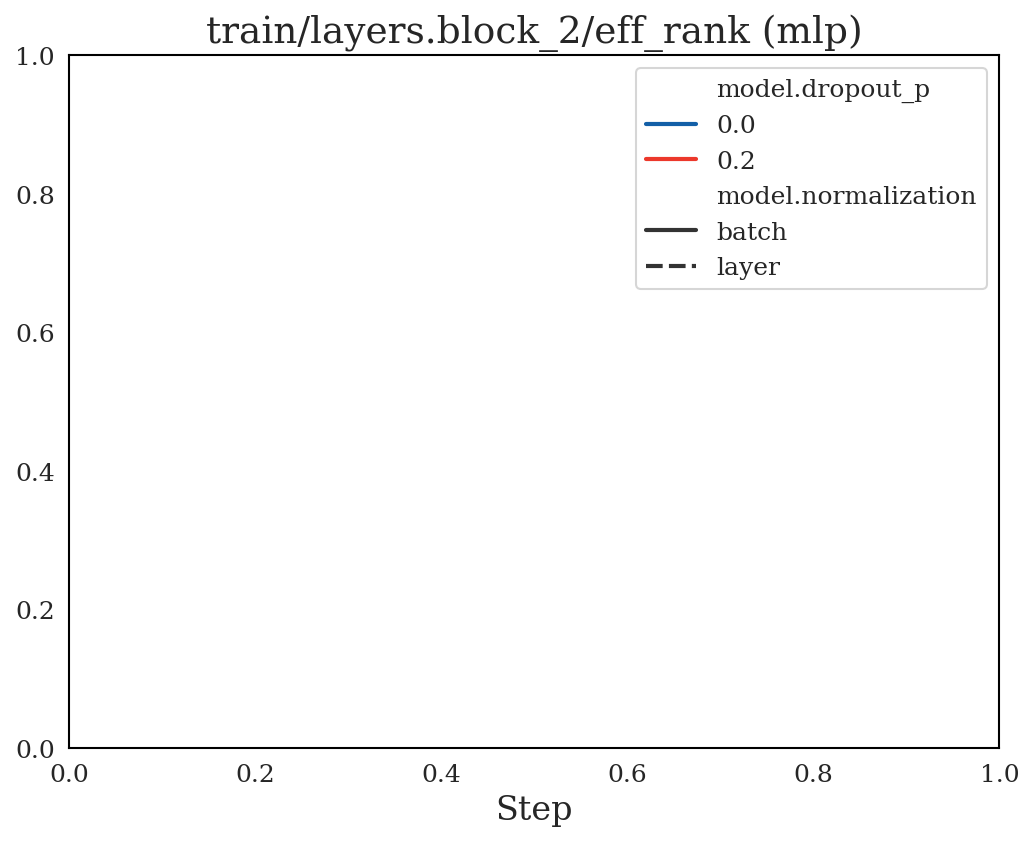

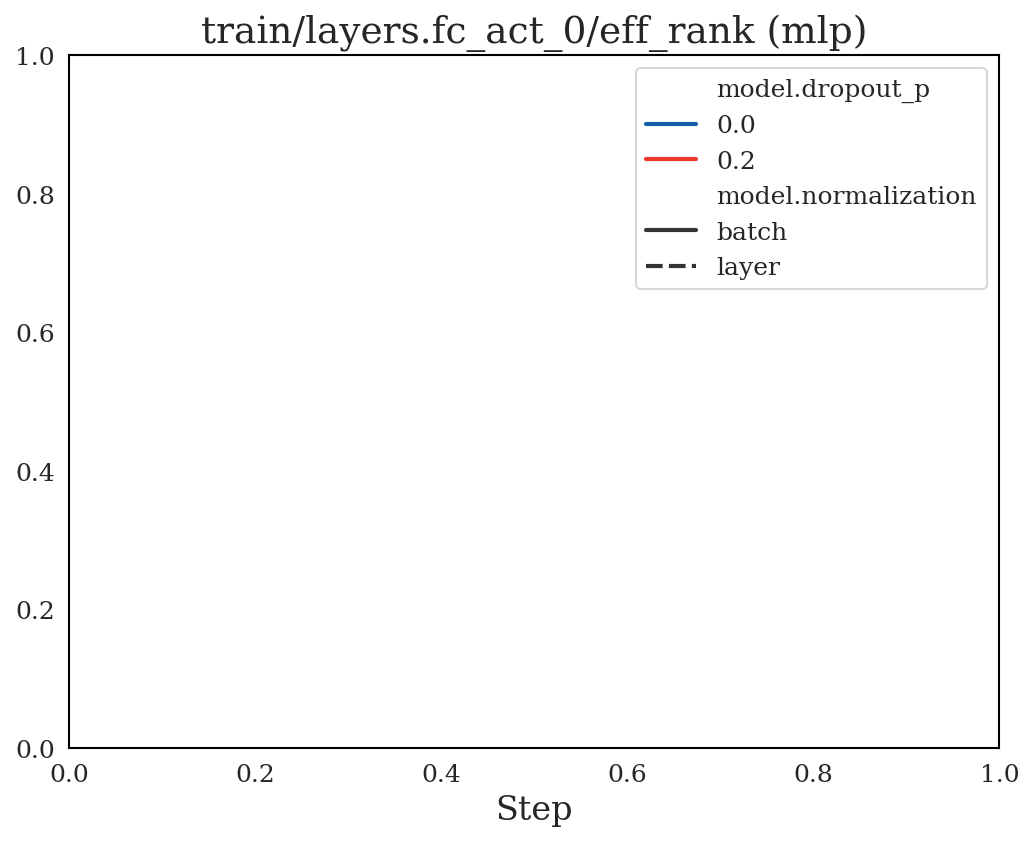

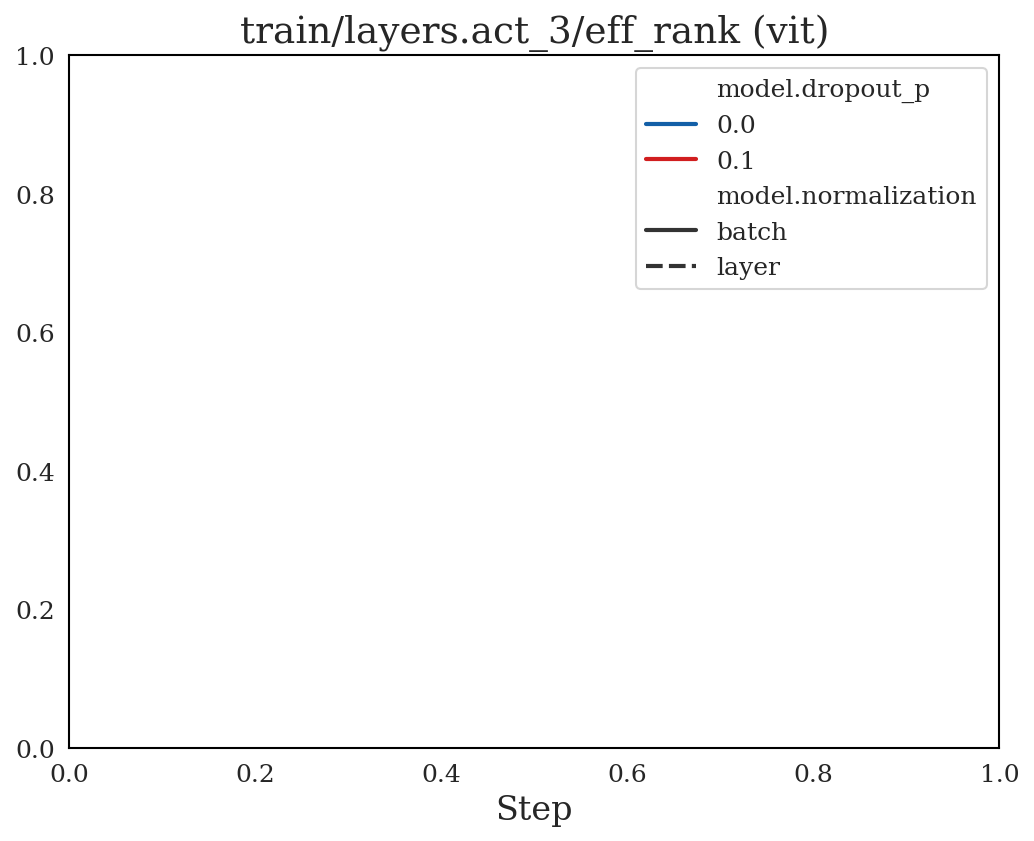

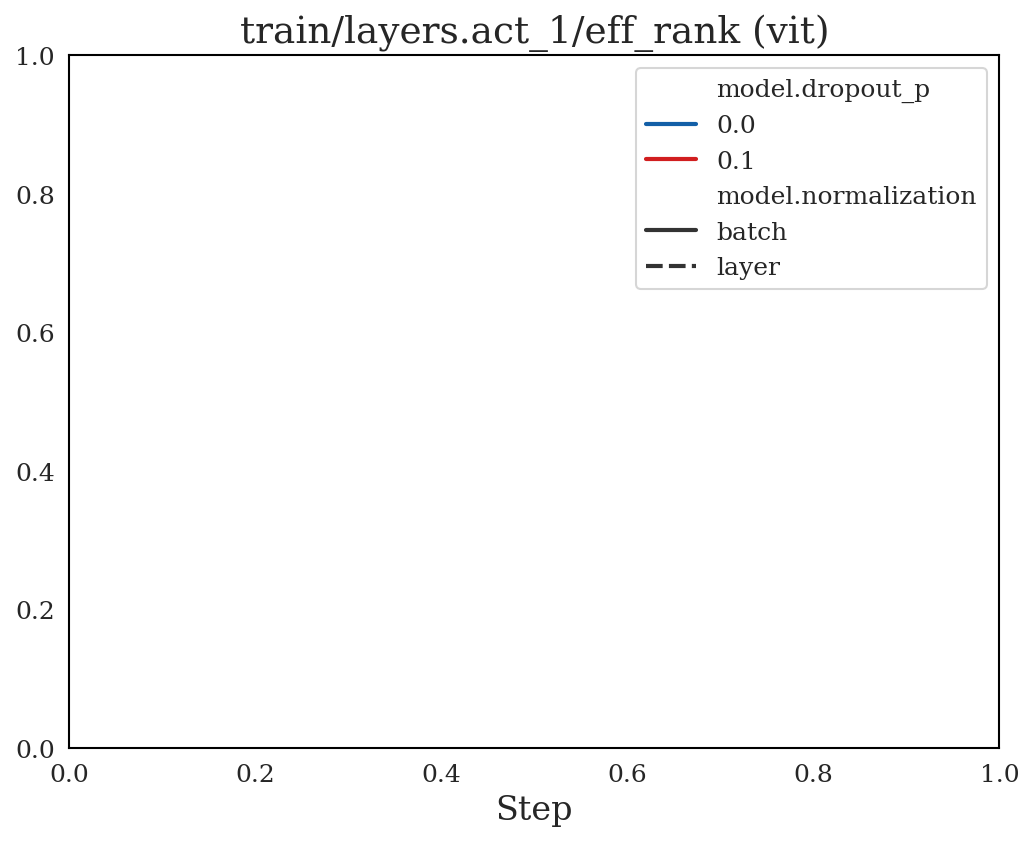

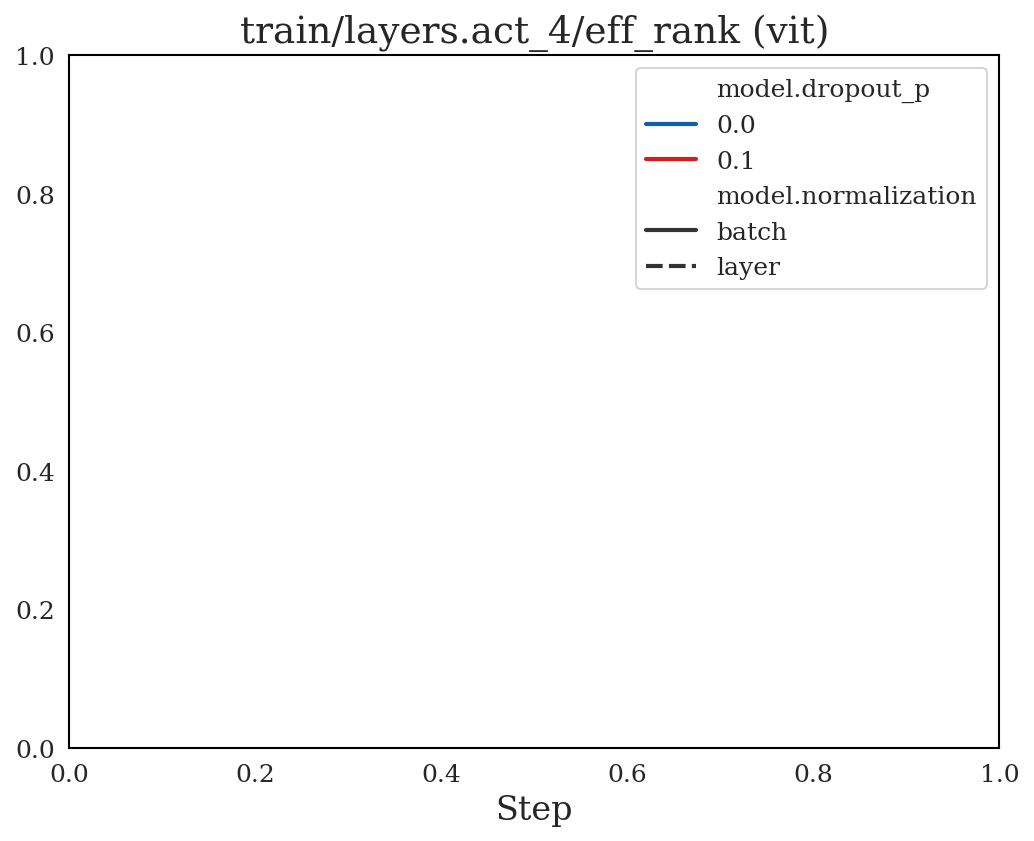

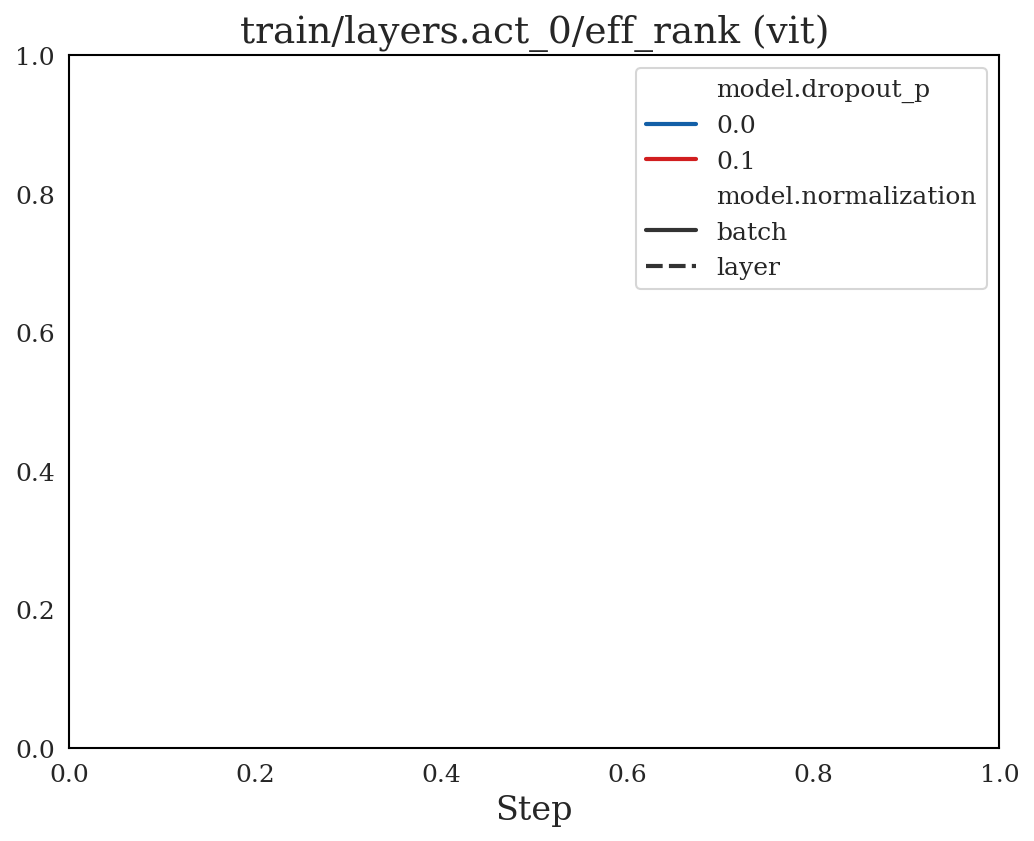

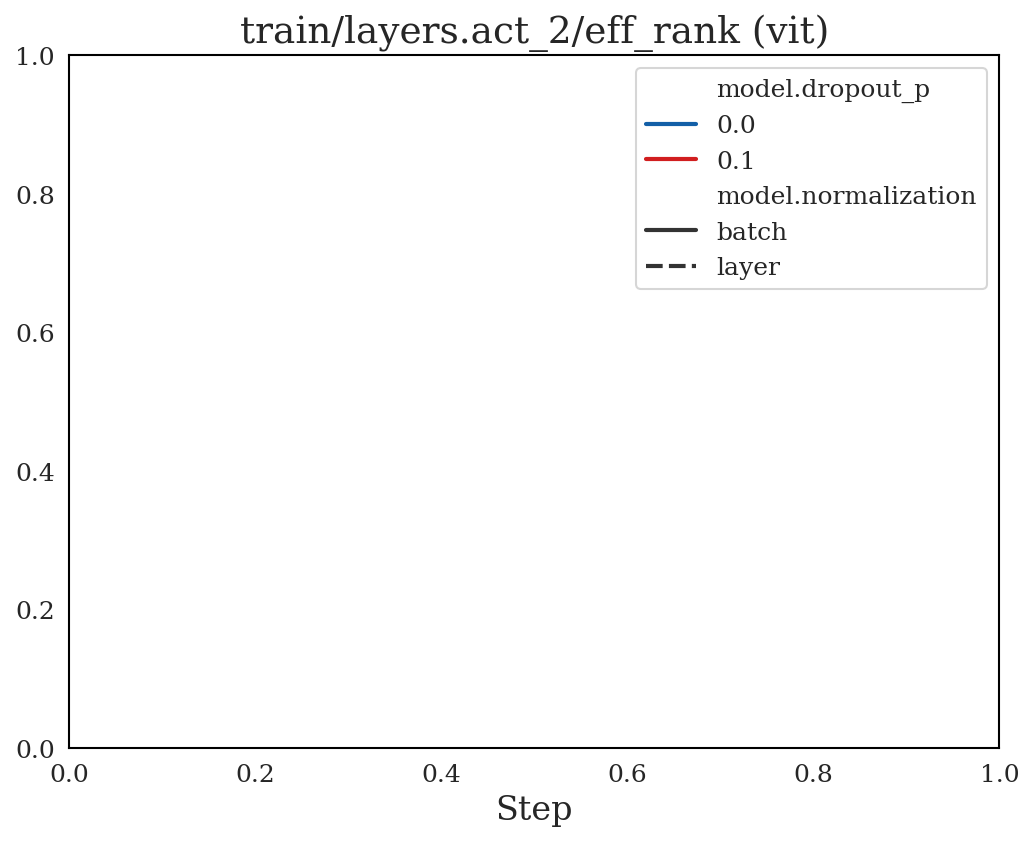

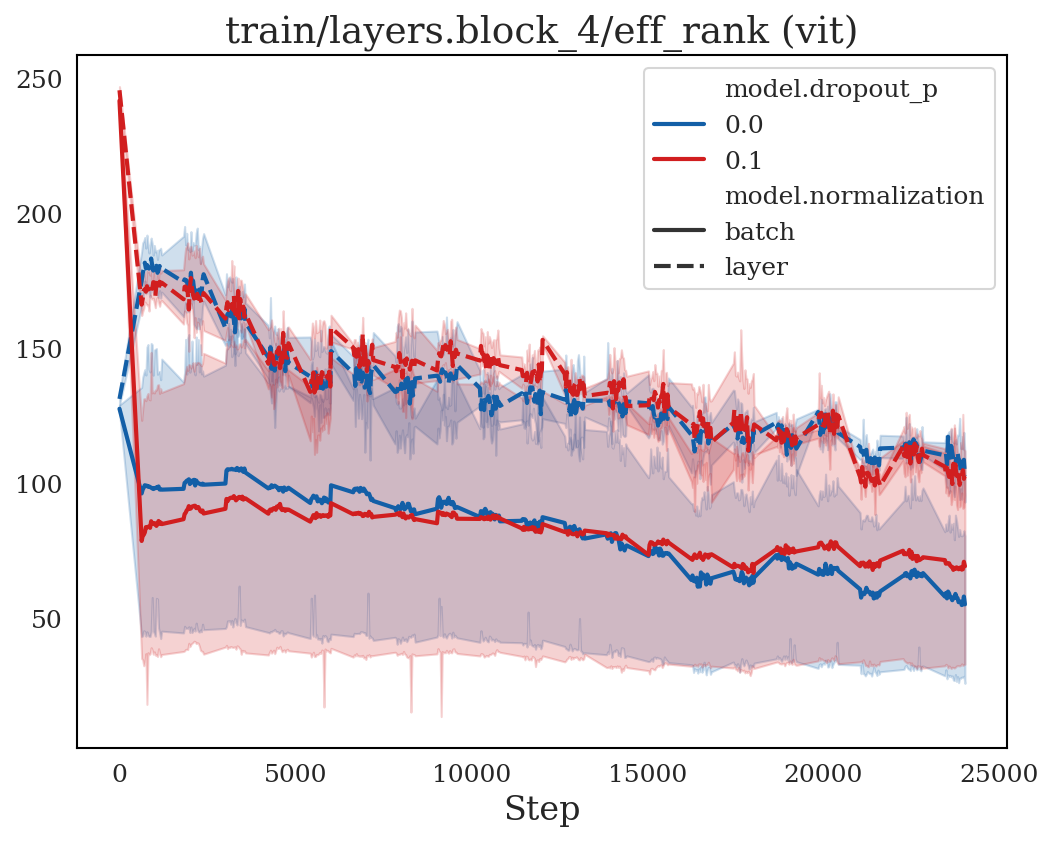

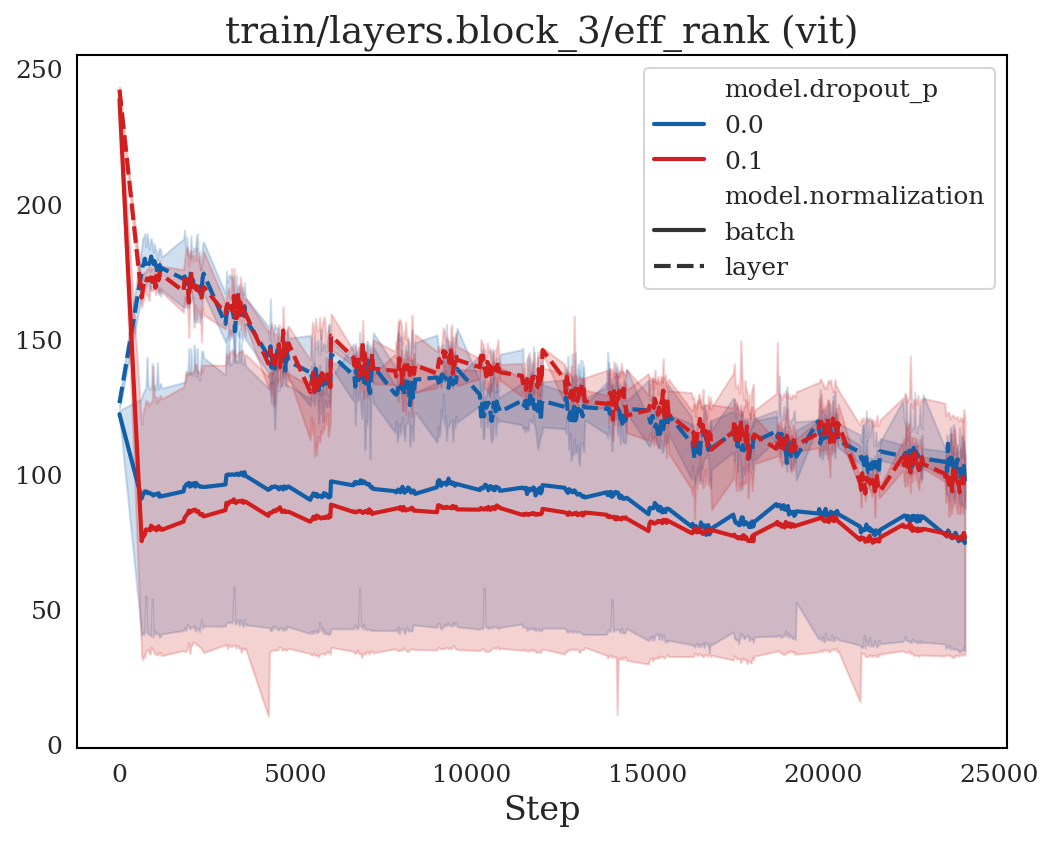

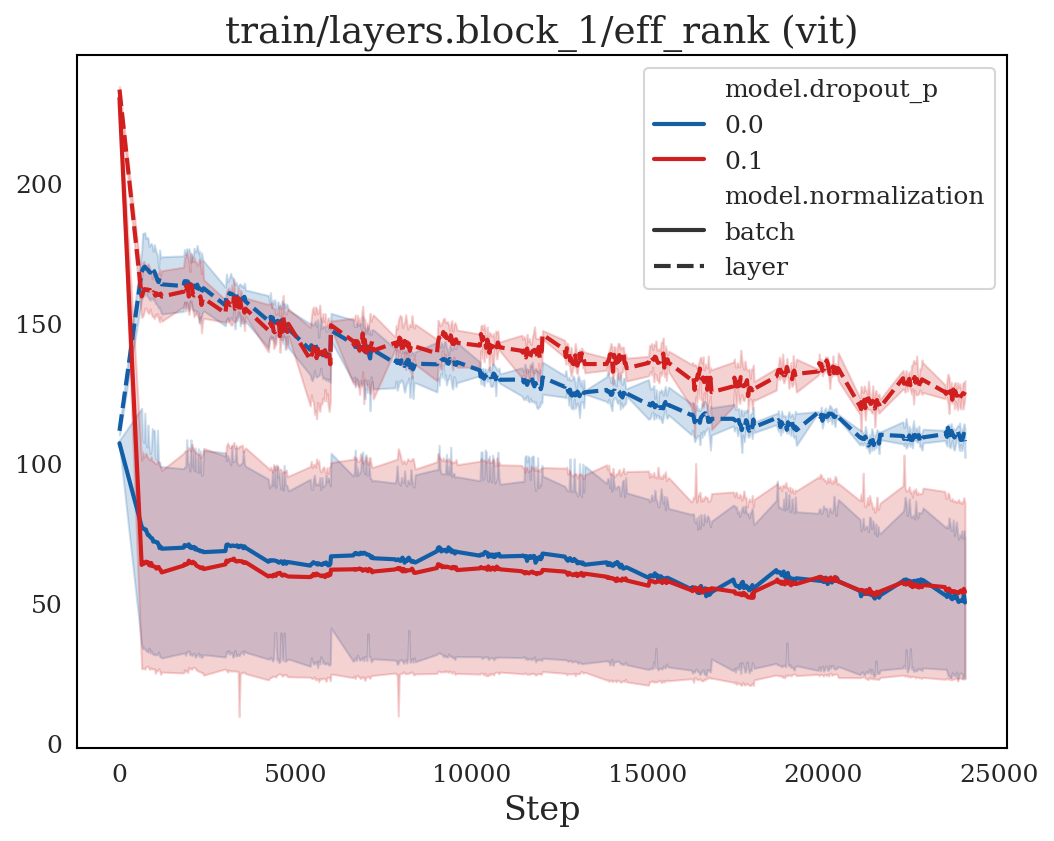

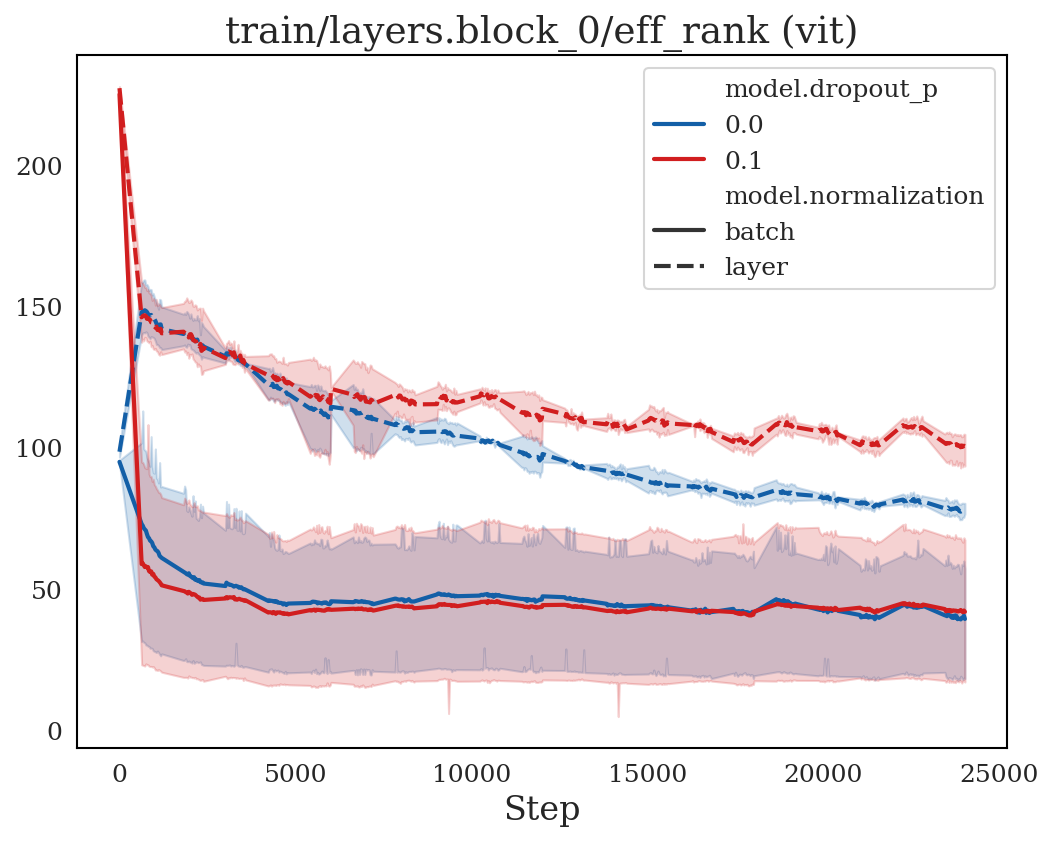

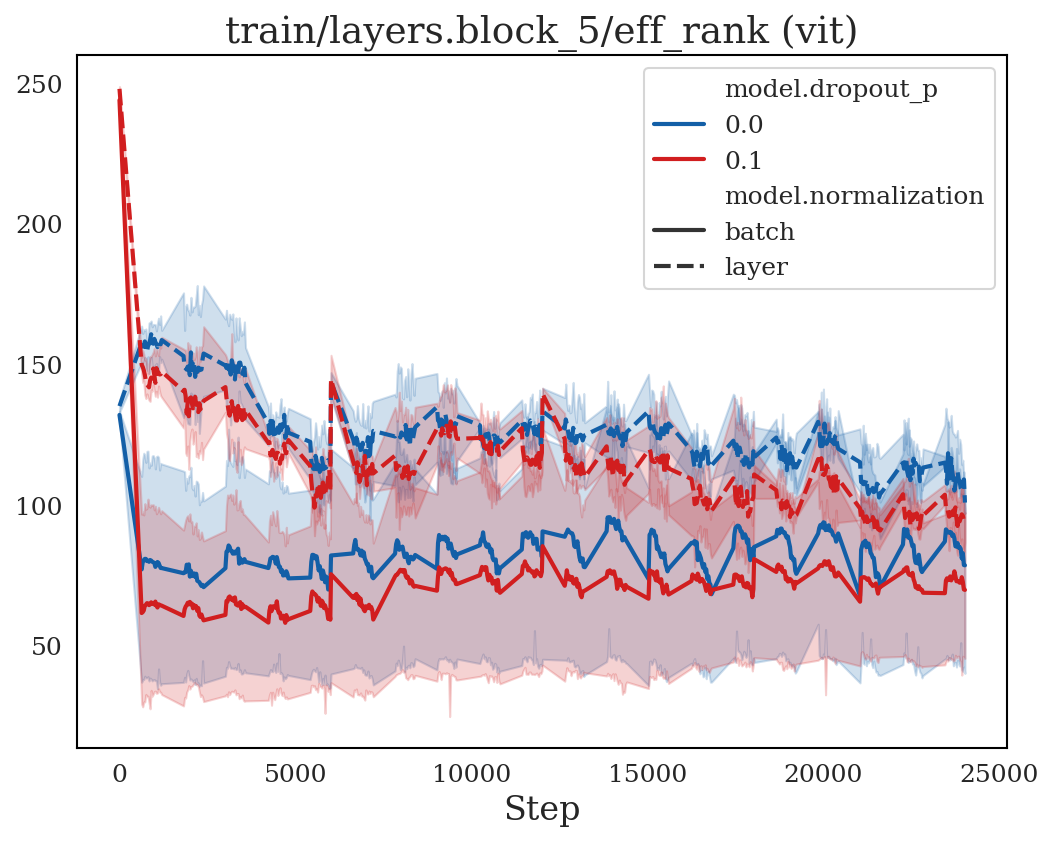

In [ ]:
# Create a custom palette with a range of reds and blues
blues = sns.color_palette("Blues", 10)
reds = sns.color_palette("Reds", 10)
custom_palette = blues + reds

# Map the custom palette to the hue values
palette_map = {0: custom_palette[8]}  # Map dropout=0 to a strong blue blue
for i, value in enumerate(df_avg['model.dropout_p'].unique()[1:], start=1):
    palette_map[value] = custom_palette[i+15]  # Map other values to reds

# Set the palette for the plot
sns.set_palette(custom_palette)

# Create a list of quantities to plot
quantities = ["dup_fraction", "eff_rank", "saturated_frac","stable_rank","non_gaussianity"]

# Create the plot
for quantity in quantities:
    for model_name in df_avg['model.name'].unique():
        q_cols = quantity_cols[("train",quantity)]
        # col = f"train_{quantity}"
        for col in q_cols:
            #df = df_avg[(df_avg['_step'] < 10000) & (df_avg['_step'] % 10 == 0) & (df_avg['model.name'] == model_name)].copy()
            df = df_avg[(df_avg['model.name'] == model_name) & (df_avg['_step'] % 10 == 0)].copy()
            plt.figure(figsize=(8, 6))  # Increase the plot size
            sns.lineplot(data=df, x='_step', y=col, hue='model.dropout_p', style='model.normalization', palette=palette_map, linewidth=2)
            plt.title(col + f" ({model_name})")
            plt.xlabel("Step")
            plt.ylabel("")
            plt.legend()
            plt.show()
